### Importing the required packages

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import scipy.stats as stats

In [6]:
import datetime as d_t

In [7]:
from sklearn.model_selection import train_test_split
import statsmodels.formula.api as smf
from sklearn.metrics import r2_score,mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels. stats.outliers_influence import variance_inflation_factor # VIF selection 
from patsy import dmatrices

In [8]:
import warnings
warnings.filterwarnings("ignore")

---

#User Defined Functions used:

In [9]:
def custom_description( x ):
    
    non_missing = x.isnull().count()
    missing = x.isnull().sum()
    missing_pct = missing / non_missing
    
    p25 = x.quantile(0.25)
    p75 = x.quantile(0.75)
    
    iqr = p75 - p25
    
    lc_iqr = p25 - 1.5 * iqr
    uc_iqr = p75 + 1.5 * iqr
    
    return pd.Series( [ x.dtype, x.count(), x.nunique(), non_missing, missing, missing_pct, 
                       x.sum(), x.var(), x.std(), x.mean(), 
                       iqr, lc_iqr, uc_iqr, 
                       x.min(), x.quantile(0.01), x.quantile(0.05), x.quantile(0.10), 
                       x.quantile(0.25), x.quantile(0.50), x.quantile(0.75), 
                       x.quantile(0.90), x.quantile(0.95), x.quantile(0.99), x.max()],
                     
                    index = ['dtype', 'rows','unique values', 'non_missing', 'missing', 'missing_pct',
                             'sum', 'var', 'std', 'mean',
                             'Interquartile Range', 'IQR lower bound', 'IQR upper bound',
                             'min', '1%', '5%', '10%', 
                             '25%', '50%', '75%', 
                             '90%', '95%', '99%', 'max'])

  ----

In [10]:
def convert_date_y2Y(date):
    """
    Converts a date string with (DD-MM-YY HH:MM) format inconsistencies to a consistent format.
    Args: date: A string representing the date.
    Returns:A string representing the date in a consistent (DD-MM-YYYY HH:MM) format.
    """
    # Split the date string into its components
    parts = date.split(" ")
    date_part = parts[0]
    time_part = parts[1] if len(parts) > 1 else None

    # Convert the date part to the desired format
    if len(date_part.split("/")[2]) == 2:
        date_part = date_part.replace("/" + date_part.split("/")[-1], "/" + "20" + date_part.split("/")[-1])
    return date_part + " " + time_part if time_part else date_part

---

In [11]:
def top_by_category(data, variable2, variable1, top_n=2):
    """
    Find the top variable1 for each variable2 based on the specified variable_to_find.

    Args:
        data (pd.DataFrame): The input DataFrame.
        variable2 (str): The column containing the category.
        variable1 (str): The column for which to find the top values.
        top_n (int): The number of top values to retrieve for each category.

    Returns:
        pd.DataFrame: A DataFrame containing the top variable1 for each variable2.
    """
    # Group by variable2 and find the top values
    top_values = (
        data.groupby([variable2, variable1])
        .size()
        .reset_index(name='count')
        .sort_values([variable2, 'count'], ascending=[True, False])
        .groupby([variable2])
        .head(top_n)
        .reset_index(drop=True)
    )

    return top_values

---

In [32]:
sales_shipment_data = pd.read_csv('Sales_Data.csv', encoding='latin-1')
inventory_stock_data= pd.read_csv('Inventory_Data.csv')

In [66]:
sales_shipment_data=sales_shipment_data.drop(['Product Image'],axis=1)
sales_shipment_data=sales_shipment_data.drop(['Product Description'],axis=1)
sales_shipment_data.head(2)

Type  Days for shipping (real)  Days for shipment (scheduled)  \
0     DEBIT                         3                              4   
1  TRANSFER                         5                              4   

   Benefit per order  Sales per customer   Delivery Status  \
0          91.250000          314.640015  Advance shipping   
1        -249.089996          311.359985     Late delivery   

   Late_delivery_risk  Category Id   Category Name Customer City  ...  \
0                   0           73  Sporting Goods        Caguas  ...   
1                   1           73  Sporting Goods        Caguas  ...   

       Order State Order Status Order Zipcode  Product Card Id  \
0  Java Occidental     COMPLETE           NaN             1360   
1         Rajastán      PENDING           NaN             1360   

  Product Category Id  Product Name Product Price Product Status  \
0                  73  Smart watch         327.75              0   
1                  73  Smart watch         327.75              0   

  shipping date (DateOrders)   Shipping Mode  
0             2/3/2018 22:56  Standard Class  
1            1/18/2018 12:27  Standard Class  

[2 rows x 51 columns]

In [102]:
#sales_shipment_data.Product_Card_Id.unique()
#sales_shipment_data.rename(columns = {'Product Card Id':'Product_Card_Id'}, inplace = True)
#print(sales_shipment_data.describe())

pd.set_option('display.max_columns', None)
sales_shipment_data.head(2)

Type  Days for shipping (real)  Days for shipment (scheduled)  \
0     DEBIT                         3                              4   
1  TRANSFER                         5                              4   

   Benefit per order  Sales per customer   Delivery Status  \
0          91.250000          314.640015  Advance shipping   
1        -249.089996          311.359985     Late delivery   

   Late_delivery_risk  Category Id   Category Name Customer City  \
0                   0           73  Sporting Goods        Caguas   
1                   1           73  Sporting Goods        Caguas   

  Customer Country Customer Email Customer Fname  Customer Id Customer Lname  \
0      Puerto Rico      XXXXXXXXX          Cally        20755       Holloway   
1      Puerto Rico      XXXXXXXXX          Irene        19492           Luna   

  Customer Password Customer Segment Customer State           Customer Street  \
0         XXXXXXXXX         Consumer             PR  5365 Noble Nectar Island   
1         XXXXXXXXX         Consumer             PR          2679 Rustic Loop   

   Customer Zipcode  Department Id Department Name   Latitude  Longitude  \
0             725.0              2         Fitness  18.251453 -66.037056   
1             725.0              2         Fitness  18.279451 -66.037064   

         Market Order City Order Country  Order Customer Id  \
0  Pacific Asia     Bekasi     Indonesia              20755   
1  Pacific Asia    Bikaner         India              19492   

  order date (DateOrders)  Order Id  Order Item Cardprod Id  \
0         1/31/2018 22:56     77202                    1360   
1         1/13/2018 12:27     75939                    1360   

   Order Item Discount  Order Item Discount Rate  Order Item Id  \
0            13.110000                      0.04         180517   
1            16.389999                      0.05         179254   

   Order Item Product Price  Order Item Profit Ratio  Order Item Quantity  \
0                    327.75                     0.29                    1   
1                    327.75                    -0.80                    1   

    Sales  Order Item Total  Order Profit Per Order    Order Region  \
0  327.75        314.640015               91.250000  Southeast Asia   
1  327.75        311.359985             -249.089996      South Asia   

       Order State Order Status  Order Zipcode  Product_Card_Id  \
0  Java Occidental     COMPLETE            NaN             1360   
1         Rajastán      PENDING            NaN             1360   

   Product Category Id  Product Name  Product Price  Product Status  \
0                   73  Smart watch          327.75               0   
1                   73  Smart watch          327.75               0   

  shipping date (DateOrders)   Shipping Mode  
0             2/3/2018 22:56  Standard Class  
1            1/18/2018 12:27  Standard Class

In [109]:
Product_ids = sales_shipment_data['Product_Card_Id'].unique().tolist()
print(Product_ids)

[1360, 365, 627, 502, 278, 249, 191, 917, 828, 642, 818, 825, 306, 977, 44, 251, 403, 957, 1352, 1349, 1351, 60, 24, 567, 893, 924, 905, 564, 885, 1363, 1353, 1357, 906, 886, 926, 116, 235, 273, 282, 359, 565, 572, 804, 822, 835, 276, 823, 203, 364, 1350, 897, 37, 172, 810, 821, 93, 1347, 305, 1004, 1346, 58, 311, 303, 1354, 1348, 78, 258, 797, 981, 1355, 135, 134, 845, 982, 625, 1359, 1356, 607, 1358, 1362, 295, 127, 61, 35, 858, 860, 216, 19, 226, 208, 793, 792, 786, 778, 777, 775, 773, 771, 768, 743, 730, 728, 725, 724, 715, 705, 703, 691, 677, 671, 666, 652, 647, 646, 1361, 1073, 1059, 1014]


In [110]:
#df1['randNumCol'] = np.random.choice([1, 9, 20], df1.shape[0])

inventory_stock_data['Product_Id']=np.random.choice(Product_ids, inventory_stock_data.shape[0])

inventory_stock_data.head(2)

Product type   SKU      Price  Availability  Number of products sold  \
0     haircare  SKU0  69.808006            55                      802   
1     skincare  SKU1  14.843523            95                      736   

   Revenue generated Customer demographics  Stock levels  Lead times  \
0        8661.996792            Non-binary            58           7   
1        7460.900065                Female            53          30   

   Order quantities  Shipping times Shipping carriers  Shipping costs  \
0                96               4         Carrier B        2.956572   
1                37               2         Carrier A        9.716575   

  Supplier name Location  Lead time  Production volumes  \
0    Supplier 3   Mumbai         29                 215   
1    Supplier 3   Mumbai         23                 517   

   Manufacturing lead time  Manufacturing costs Inspection results  \
0                       29            46.279879            Pending   
1                       30            33.616769            Pending   

   Defect rates Transportation modes   Routes       Costs  Product_Id  
0      0.226410                 Road  Route B  187.752075         743  
1      4.854068                 Road  Route B  503.065579         572

In [67]:
# Display the number of rows and columns for each dataset
print("Sales_Shipment_Data:",sales_shipment_data.shape)
print(f"Inventory_Stock_Data:",inventory_stock_data.shape)

Sales_Shipment_Data: (180519, 51)
Inventory_Stock_Data: (100, 24)


> Sales_Shipment_Data: Number of rows = 180519, Number of columns = 46 <br>
> Inventory_Stock_Data: Number of rows = 118, Number of columns = 11

In [68]:
# Calculate the number of numerical and categorical columns for Sales_Shipment_Data
numerical_columns_sales = sales_shipment_data.select_dtypes(include=['number']).shape[1]
categorical_columns_sales = sales_shipment_data.select_dtypes(include=['object']).shape[1]

# Calculate the number of numerical and categorical columns for Inventory_Stock_Data
numerical_columns_inventory = inventory_stock_data.select_dtypes(include=['number']).shape[1]
categorical_columns_inventory = inventory_stock_data.select_dtypes(include=['object']).shape[1]

print(f"Sales_Shipment_Data: Number of Numerical Columns = {numerical_columns_sales}, Number of Categorical Columns = {categorical_columns_sales}")
print(f"Inventory_Stock_Data: Number of Numerical Columns = {numerical_columns_inventory}, Number of Categorical Columns = {categorical_columns_inventory}")

Sales_Shipment_Data: Number of Numerical Columns = 28, Number of Categorical Columns = 23
Inventory_Stock_Data: Number of Numerical Columns = 15, Number of Categorical Columns = 9


> Considering the numerical variables of the data to check the Measures of Central Tendency, Measures of Spread / Dispersion

In [69]:
# Numerical columns for univariate analysis
numerical_columns_sales = sales_shipment_data.select_dtypes(include=['number']).columns
numerical_columns_inventory = inventory_stock_data.select_dtypes(include=['number']).columns

print(numerical_columns_sales)

Index(['Days for shipping (real)', 'Days for shipment (scheduled)',
       'Benefit per order', 'Sales per customer', 'Late_delivery_risk',
       'Category Id', 'Customer Id', 'Customer Zipcode', 'Department Id',
       'Latitude', 'Longitude', 'Order Customer Id', 'Order Id',
       'Order Item Cardprod Id', 'Order Item Discount',
       'Order Item Discount Rate', 'Order Item Id', 'Order Item Product Price',
       'Order Item Profit Ratio', 'Order Item Quantity', 'Sales',
       'Order Item Total', 'Order Profit Per Order', 'Order Zipcode',
       'Product Card Id', 'Product Category Id', 'Product Price',
       'Product Status'],
      dtype='object')


In [70]:
print("Univariate Analysis (Descriptive Statistics) for Sales_Shipment_Data:")
sales_shipment_data.select_dtypes(include=['number']).apply(custom_description)

Univariate Analysis (Descriptive Statistics) for Sales_Shipment_Data:


Days for shipping (real) Days for shipment (scheduled)  \
dtype                                  int64                         int64   
rows                                  180519                        180519   
unique values                              7                             4   
non_missing                           180519                        180519   
missing                                    0                             0   
missing_pct                              0.0                           0.0   
sum                                   631393                        529254   
var                                 2.636473                      1.889111   
std                                 1.623722                      1.374449   
mean                                3.497654                      2.931847   
Interquartile Range                      3.0                           2.0   
IQR lower bound                         -2.5                          -1.0   
IQR upper bound                          9.5                           7.0   
min                                        0                             0   
1%                                       0.0                           0.0   
5%                                       1.0                           0.0   
10%                                      2.0                           1.0   
25%                                      2.0                           2.0   
50%                                      3.0                           4.0   
75%                                      5.0                           4.0   
90%                                      6.0                           4.0   
95%                                      6.0                           4.0   
99%                                      6.0                           4.0   
max                                        6                             4   

                    Benefit per order Sales per customer Late_delivery_risk  \
dtype                         float64            float64              int64   
rows                           180519             180519             180519   
unique values                   21998               2927                  2   
non_missing                    180519             180519             180519   
missing                             0                  0                  0   
missing_pct                       0.0                0.0                0.0   
sum                     3966902.97405    33054402.380217              98977   
var                        10906.3613       14410.482714           0.247669   
std                        104.433526          120.04367           0.497664   
mean                        21.974989         183.107609           0.548291   
Interquartile Range         57.800003         143.019997                1.0   
IQR lower bound            -79.700005        -110.149998               -1.5   
IQR upper bound            151.500008         461.929989                2.5   
min                       -4274.97998               7.49                  0   
1%                        -415.599402              22.49                0.0   
5%                        -139.250999               41.5                0.0   
10%                           -49.522          50.389999                0.0   
25%                               7.0         104.379997                0.0   
50%                             31.52         163.990005                1.0   
75%                         64.800003         247.399994                1.0   
90%                        105.190002         346.390015                1.0   
95%                        132.289993         383.980011                1.0   
99%                        184.229996         464.950012                1.0   
max                        911.799988         1939.98999                  1   

                    Category Id      Customer Id   Customer Zipcode  \
dtype                 

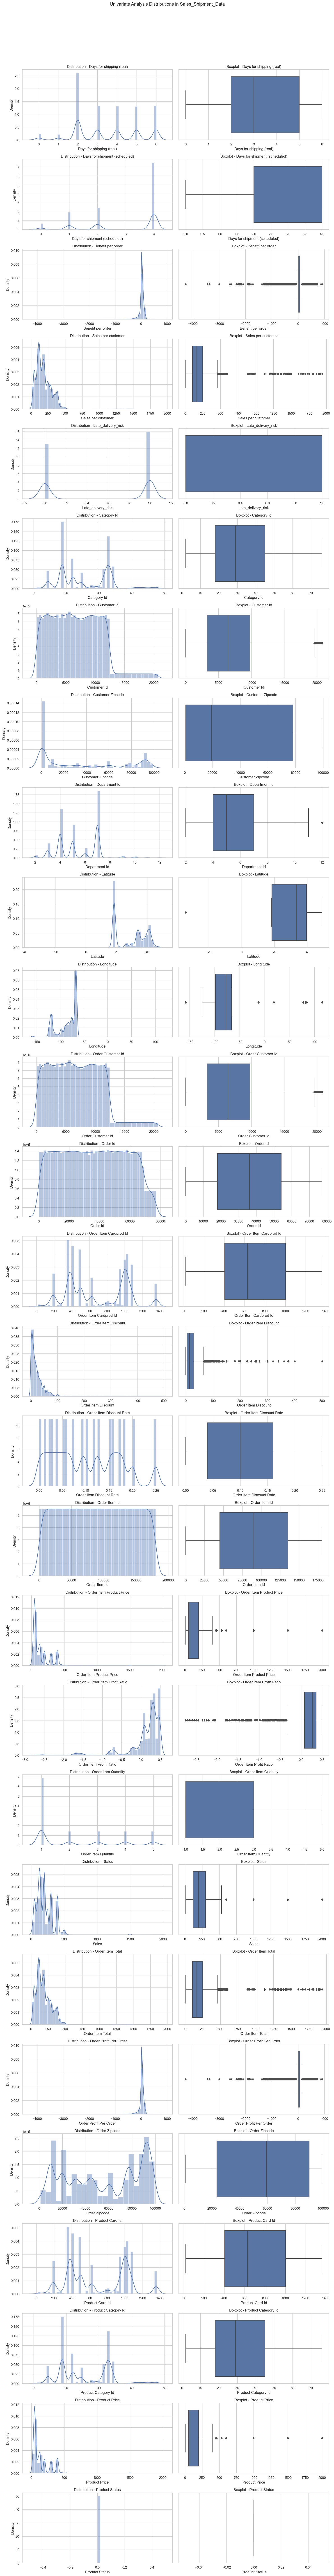

In [71]:
# Set the style for seaborn plots
sns.set(style="whitegrid")

# Set up subplots
fig, axes = plt.subplots(nrows=len(numerical_columns_sales), ncols=2, figsize=(15, 4 * len(numerical_columns_sales)))
fig.suptitle('Univariate Analysis Distributions in Sales_Shipment_Data', y=1.02)

# Plot distplot and boxplot side by side for each numerical variable in Sales_Shipment_Data
for i, column in enumerate(numerical_columns_sales):
    sns.distplot(sales_shipment_data[column], ax=axes[i, 0], kde_kws={'bw': 0.1})
    axes[i, 0].set_title(f'Distribution - {column}')
    
    sns.boxplot(x=sales_shipment_data[column], ax=axes[i, 1])
    axes[i, 1].set_title(f'Boxplot - {column}')

plt.tight_layout()
plt.show()

> majority of vaiables are not normally distributed

___

In [72]:
print()
print("Univariate Analysis for inventory_stock_data:")

inventory_stock_data.select_dtypes(include=['number']).apply(custom_description)


Univariate Analysis for inventory_stock_data:


Price Availability Number of products sold  \
dtype                    float64        int64                   int64   
rows                         100          100                     100   
unique values                100           63                      96   
non_missing                  100          100                     100   
missing                        0            0                       0   
missing_pct                  0.0          0.0                     0.0   
sum                  4946.246134         4840                   46099   
var                   971.456238   945.151515            92282.333232   
std                    31.168193    30.743317              303.780074   
mean                   49.462461         48.4                  460.99   
Interquartile Range    57.600405        52.25                   520.0   
IQR lower bound       -66.802784      -55.625                 -595.75   
IQR upper bound       163.598835      153.375                 1484.25   
min                     1.699976            1                       8   
1%                      2.390302          1.0                   23.84   
5%                      4.050722         5.95                    60.5   
10%                     6.374068         10.9                    98.4   
25%                    19.597823        22.75                  184.25   
50%                    51.239831         43.5                   392.5   
75%                    77.198228         75.0                  704.25   
90%                    90.684746         93.0                   913.3   
95%                    96.396366        96.05                  960.15   
99%                    99.113872        99.01                  987.09   
max                    99.171329          100                     996   

                    Revenue generated Stock levels Lead times  \
dtype                         float64        int64      int64   
rows                              100          100        100   
unique values                     100           65         29   
non_missing                       100          100        100   
missing                             0            0          0   
missing_pct                       0.0          0.0        0.0   
sum                     577604.818738         4777       1596   
var                    7468423.999463   984.037475  77.190303   
std                       2732.841744    31.369372   8.785801   
mean                      5776.048187        47.77      15.96   
Interquartile Range        5441.12977        56.25       16.0   
IQR lower bound          -5348.847503      -67.625      -16.0   
IQR upper bound          16415.671575      157.375       48.0   
min                       1061.618523            0          1   
1%                        1227.911304         0.99        1.0   
5%                        1835.248009          4.0        1.0   
10%                       2045.576071          5.0        3.9   
25%                       2812.847151        16.75        8.0   
50%                       6006.352023         47.5       17.0   
75%                       8253.976921         73.0       24.0   
90%                       9203.134597         93.0       27.0   
95%                       9571.860444         97.0       29.0   
99%                       9694.059514        100.0       30.0   
max                       9866.465458          100         30   

                    Order quantities Shipping times Shipping costs  Lead time  \
dtype                          int64          int64        float64      int64   
rows                             100            100            100        100   
unique values                     61             10            100         29   
non_missing                      100            100            100        100   
missing                            0              0              0          0   
missing_pct                      0.0            0.0            0.0        0.0   
sum     

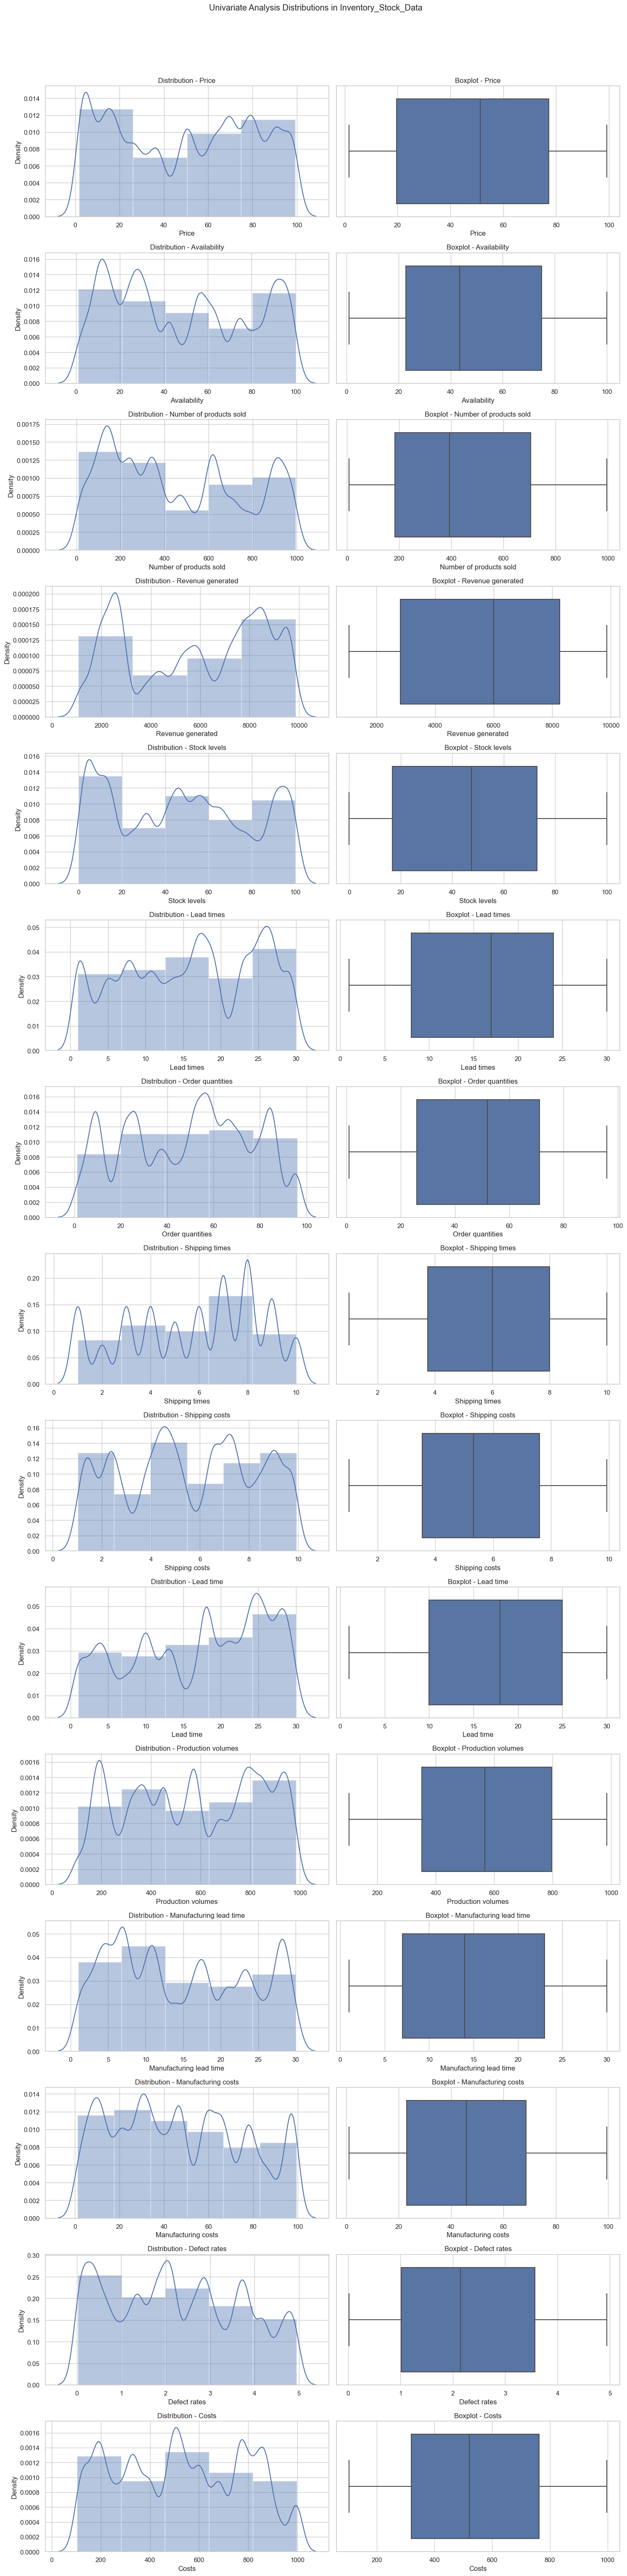

In [73]:
# Set up subplots for Inventory_Stock_Data
fig, axes = plt.subplots(nrows=len(numerical_columns_inventory), ncols=2, 
                         figsize=(15, 4 * len(numerical_columns_inventory)))
fig.suptitle('Univariate Analysis Distributions in Inventory_Stock_Data', y=1.02)


# Plot distplot and boxplot side by side for each numerical variable in Inventory_Stock_Data
for i, column in enumerate(numerical_columns_inventory):
    sns.distplot(inventory_stock_data[column], ax=axes[i, 0], kde_kws={'bw': 0.1})
    axes[i, 0].set_title(f'Distribution - {column}')
    
    sns.boxplot(x=inventory_stock_data[column], ax=axes[i, 1])
    axes[i, 1].set_title(f'Boxplot - {column}')

plt.tight_layout()
plt.show()

___

In [74]:
# Categorical columns for univariate analysis
categorical_columns_sales = sales_shipment_data.select_dtypes(include=['object']).columns
categorical_columns_inventory = inventory_stock_data.select_dtypes(include=['object']).columns

> Easing ploting by not considering some variables
>* we have 22 categorical columns 
>* since counting some of the variables don't make sense for analysis
>* we are not considering them here

In [75]:
categorical_columns_sales= categorical_columns_sales.difference(['Customer City','Customer Fname', 
                                     'Customer State','Category Name','Customer Lname','Customer Street',
                                     'order date (DateOrders)','Product Name','shipping date (DateOrders)',
                                         'Order City', 'Order State','Order Country'])
categorical_columns_sales

Index(['Customer Country', 'Customer Email', 'Customer Password',
       'Customer Segment', 'Delivery Status', 'Department Name', 'Market',
       'Order Region', 'Order Status', 'Shipping Mode', 'Type'],
      dtype='object')

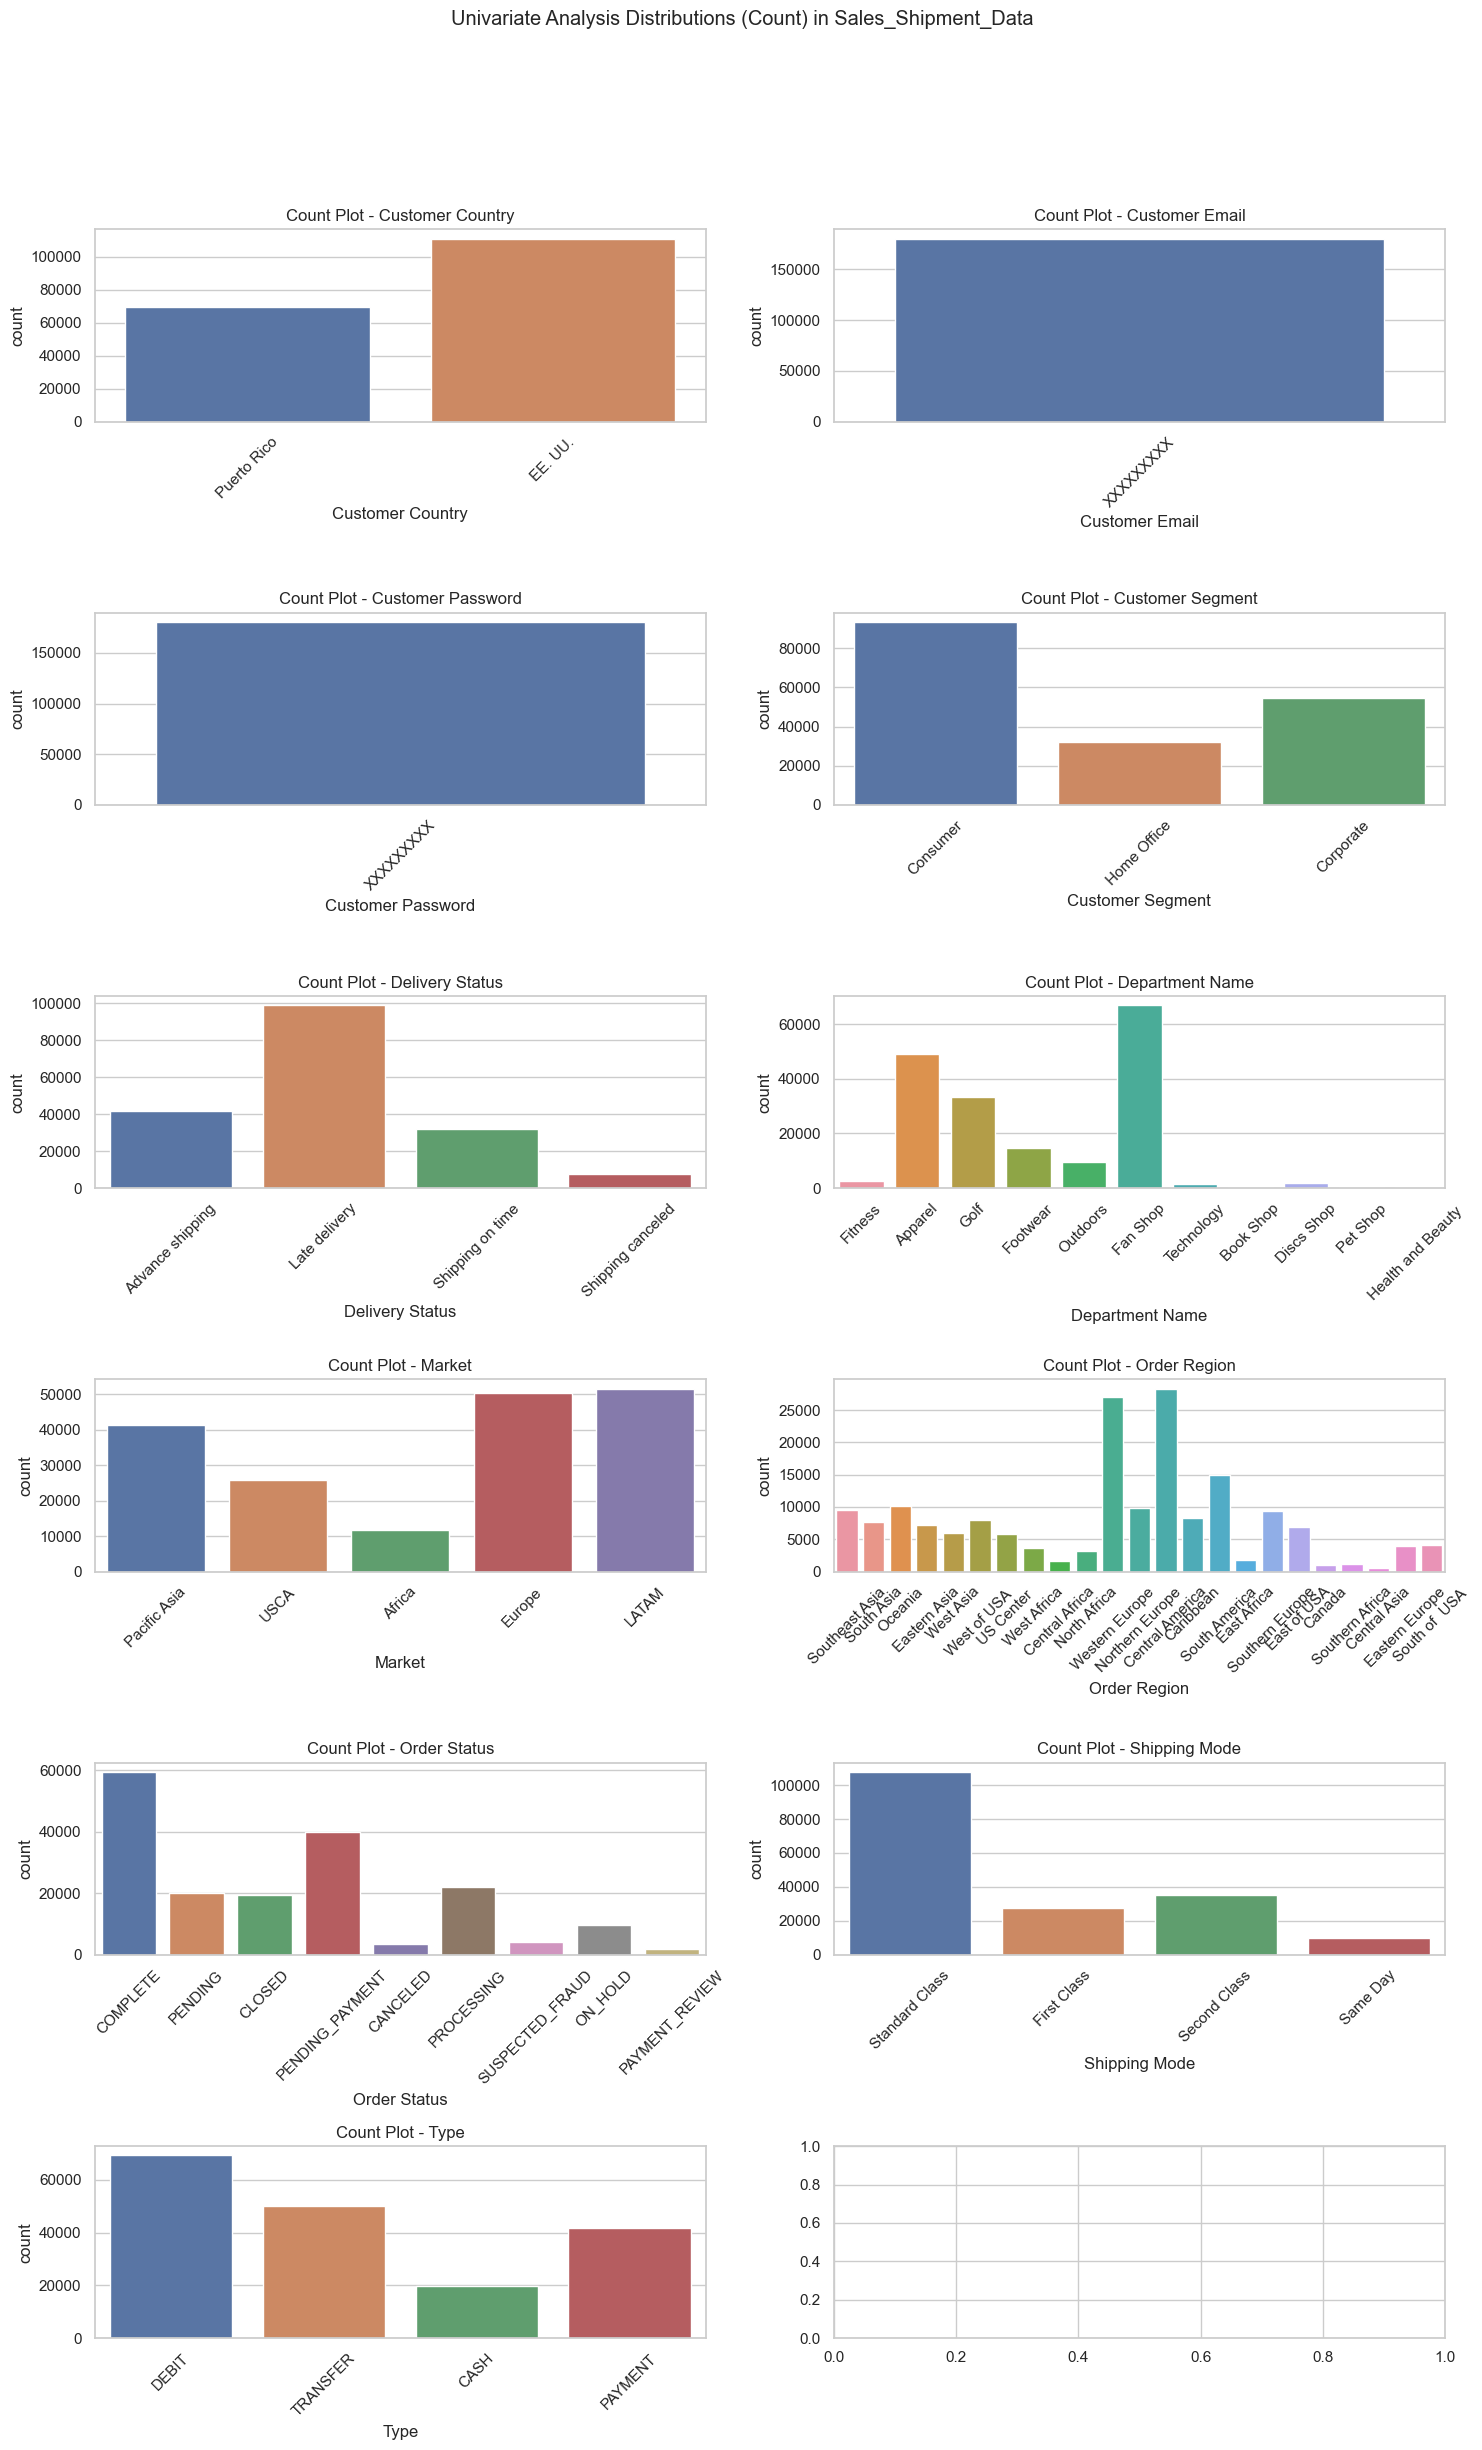

In [76]:
# Set the style for seaborn plots
sns.set(style="whitegrid")

# Set up subplots for Sales_Shipment_Data
n_cols = 2  # Number of columns in each row
n_rows = (len(categorical_columns_sales) + n_cols - 1) // n_cols  # Calculate the number of rows

fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(15, 4 * n_rows))
fig.suptitle('Univariate Analysis Distributions (Count) in Sales_Shipment_Data', y=1.02)

# Plot count plots for each categorical variable in Sales_Shipment_Data
for i, column in enumerate(categorical_columns_sales):
    ax = axes[i // n_cols, i % n_cols]
    sns.countplot(x=sales_shipment_data[column], ax=ax)
    ax.set_title(f'Count Plot - {column}')
    ax.tick_params(axis='x', rotation=45)

# Adjust layout to prevent overlapping titles
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

In [77]:
categorical_columns_inventory

Index(['Product type', 'SKU', 'Customer demographics', 'Shipping carriers',
       'Supplier name', 'Location', 'Inspection results',
       'Transportation modes', 'Routes'],
      dtype='object')

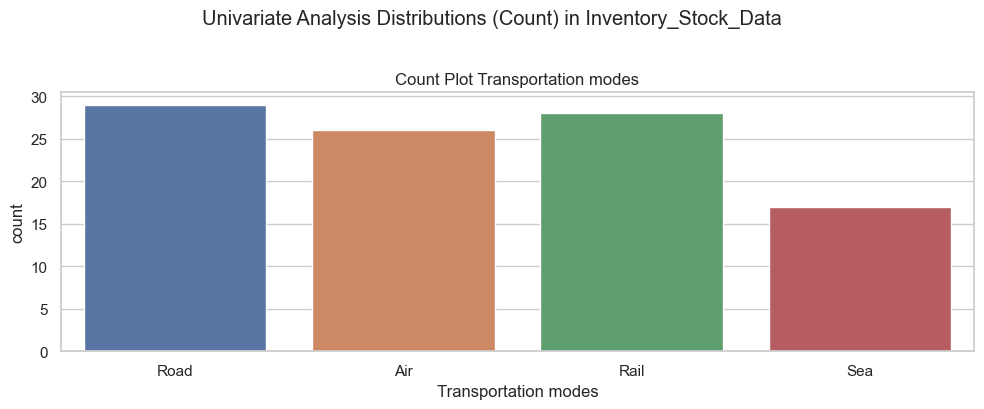

In [79]:
# Set the style for seaborn plots
sns.set_theme(style="whitegrid")

# Set up subplots for Inventory_Stock_Data
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10, 4))
fig.suptitle('Univariate Analysis Distributions (Count) in Inventory_Stock_Data', y=1.02)

# Plot count plots for each categorical variable in Inventory_Stock_Data
#sns.countplot(x=inventory_stock_data['order-now']).set_title(f'Count Plot Order-now')
sns.countplot(x=inventory_stock_data['Transportation modes']).set_title(f'Count Plot Transportation modes')


plt.tight_layout()
plt.show()

---

#### Bi Variate Analysis:
- Measure of Relation

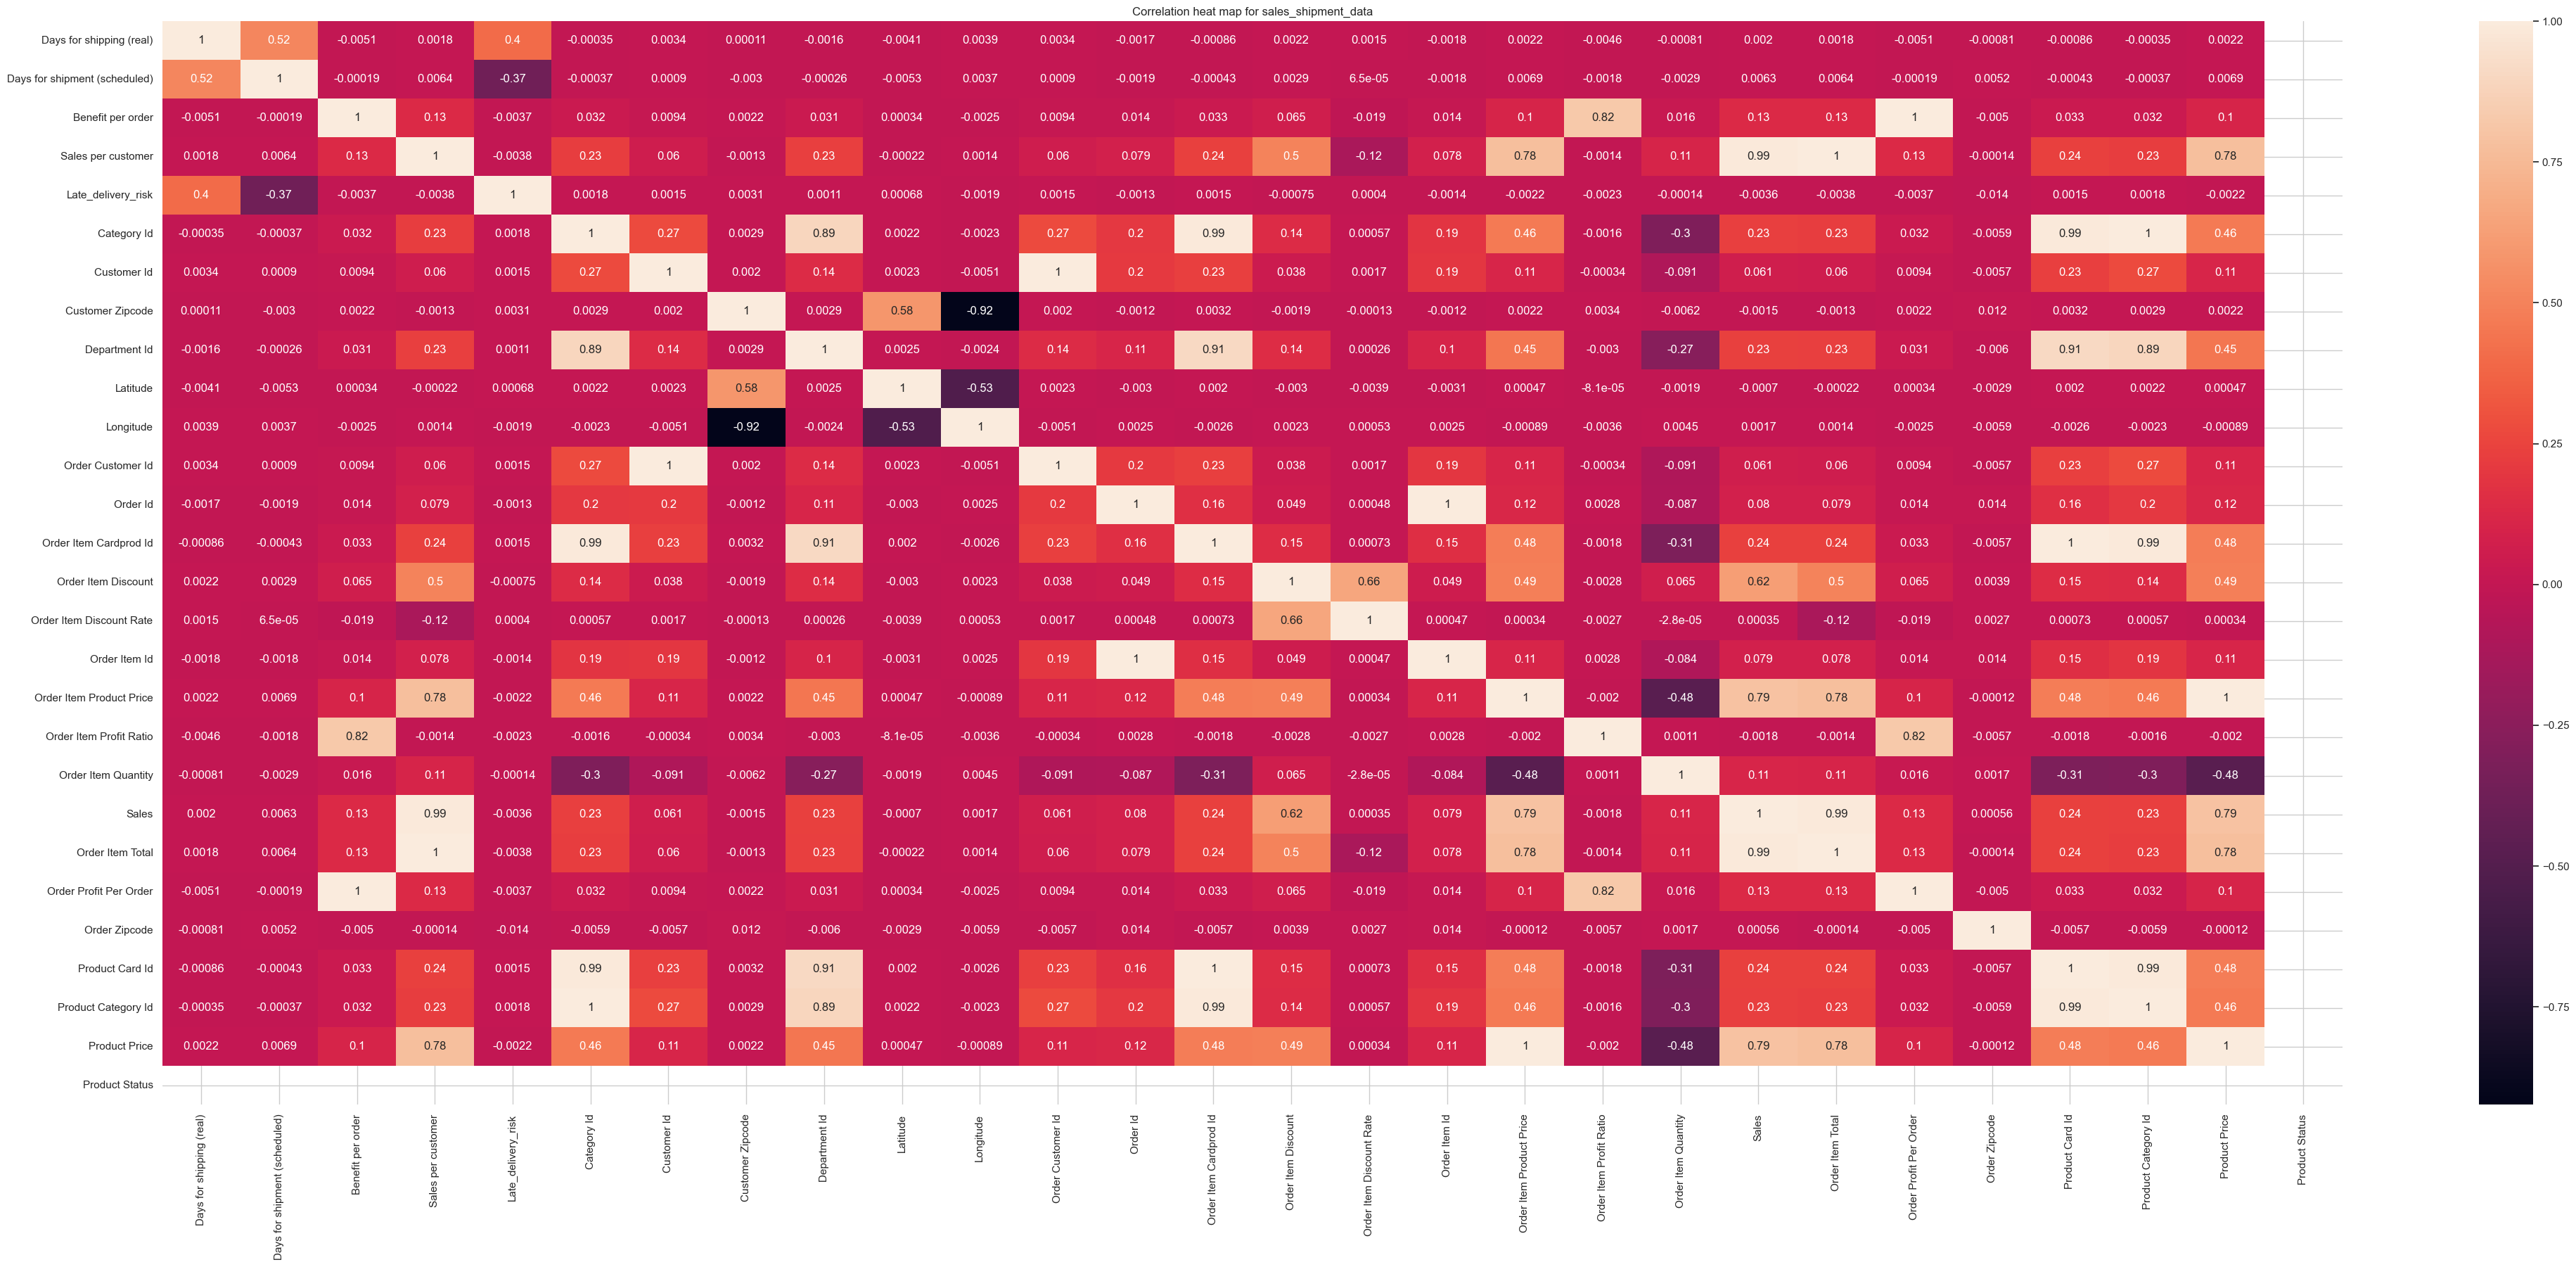

In [83]:
plt.figure(figsize=(50,20))
htmp = sns.heatmap(sales_shipment_data.select_dtypes(include=['number']).corr(),annot=True)
htmp.set_title('Correlation heat map for sales_shipment_data')
plt.show()

> By analysing correlation heatmap, I could notice the,
>* Positive correlation from
    * Product Category ID (0.23)
    * Department ID (0.23)
    * Product ID (0.24)
    * Order Item Discount (0.62)
    * Order Item Product Price (0.79)
    * Order Item Total (0.99)
    * Product Price (0.79)
> * with our Target variable Sales

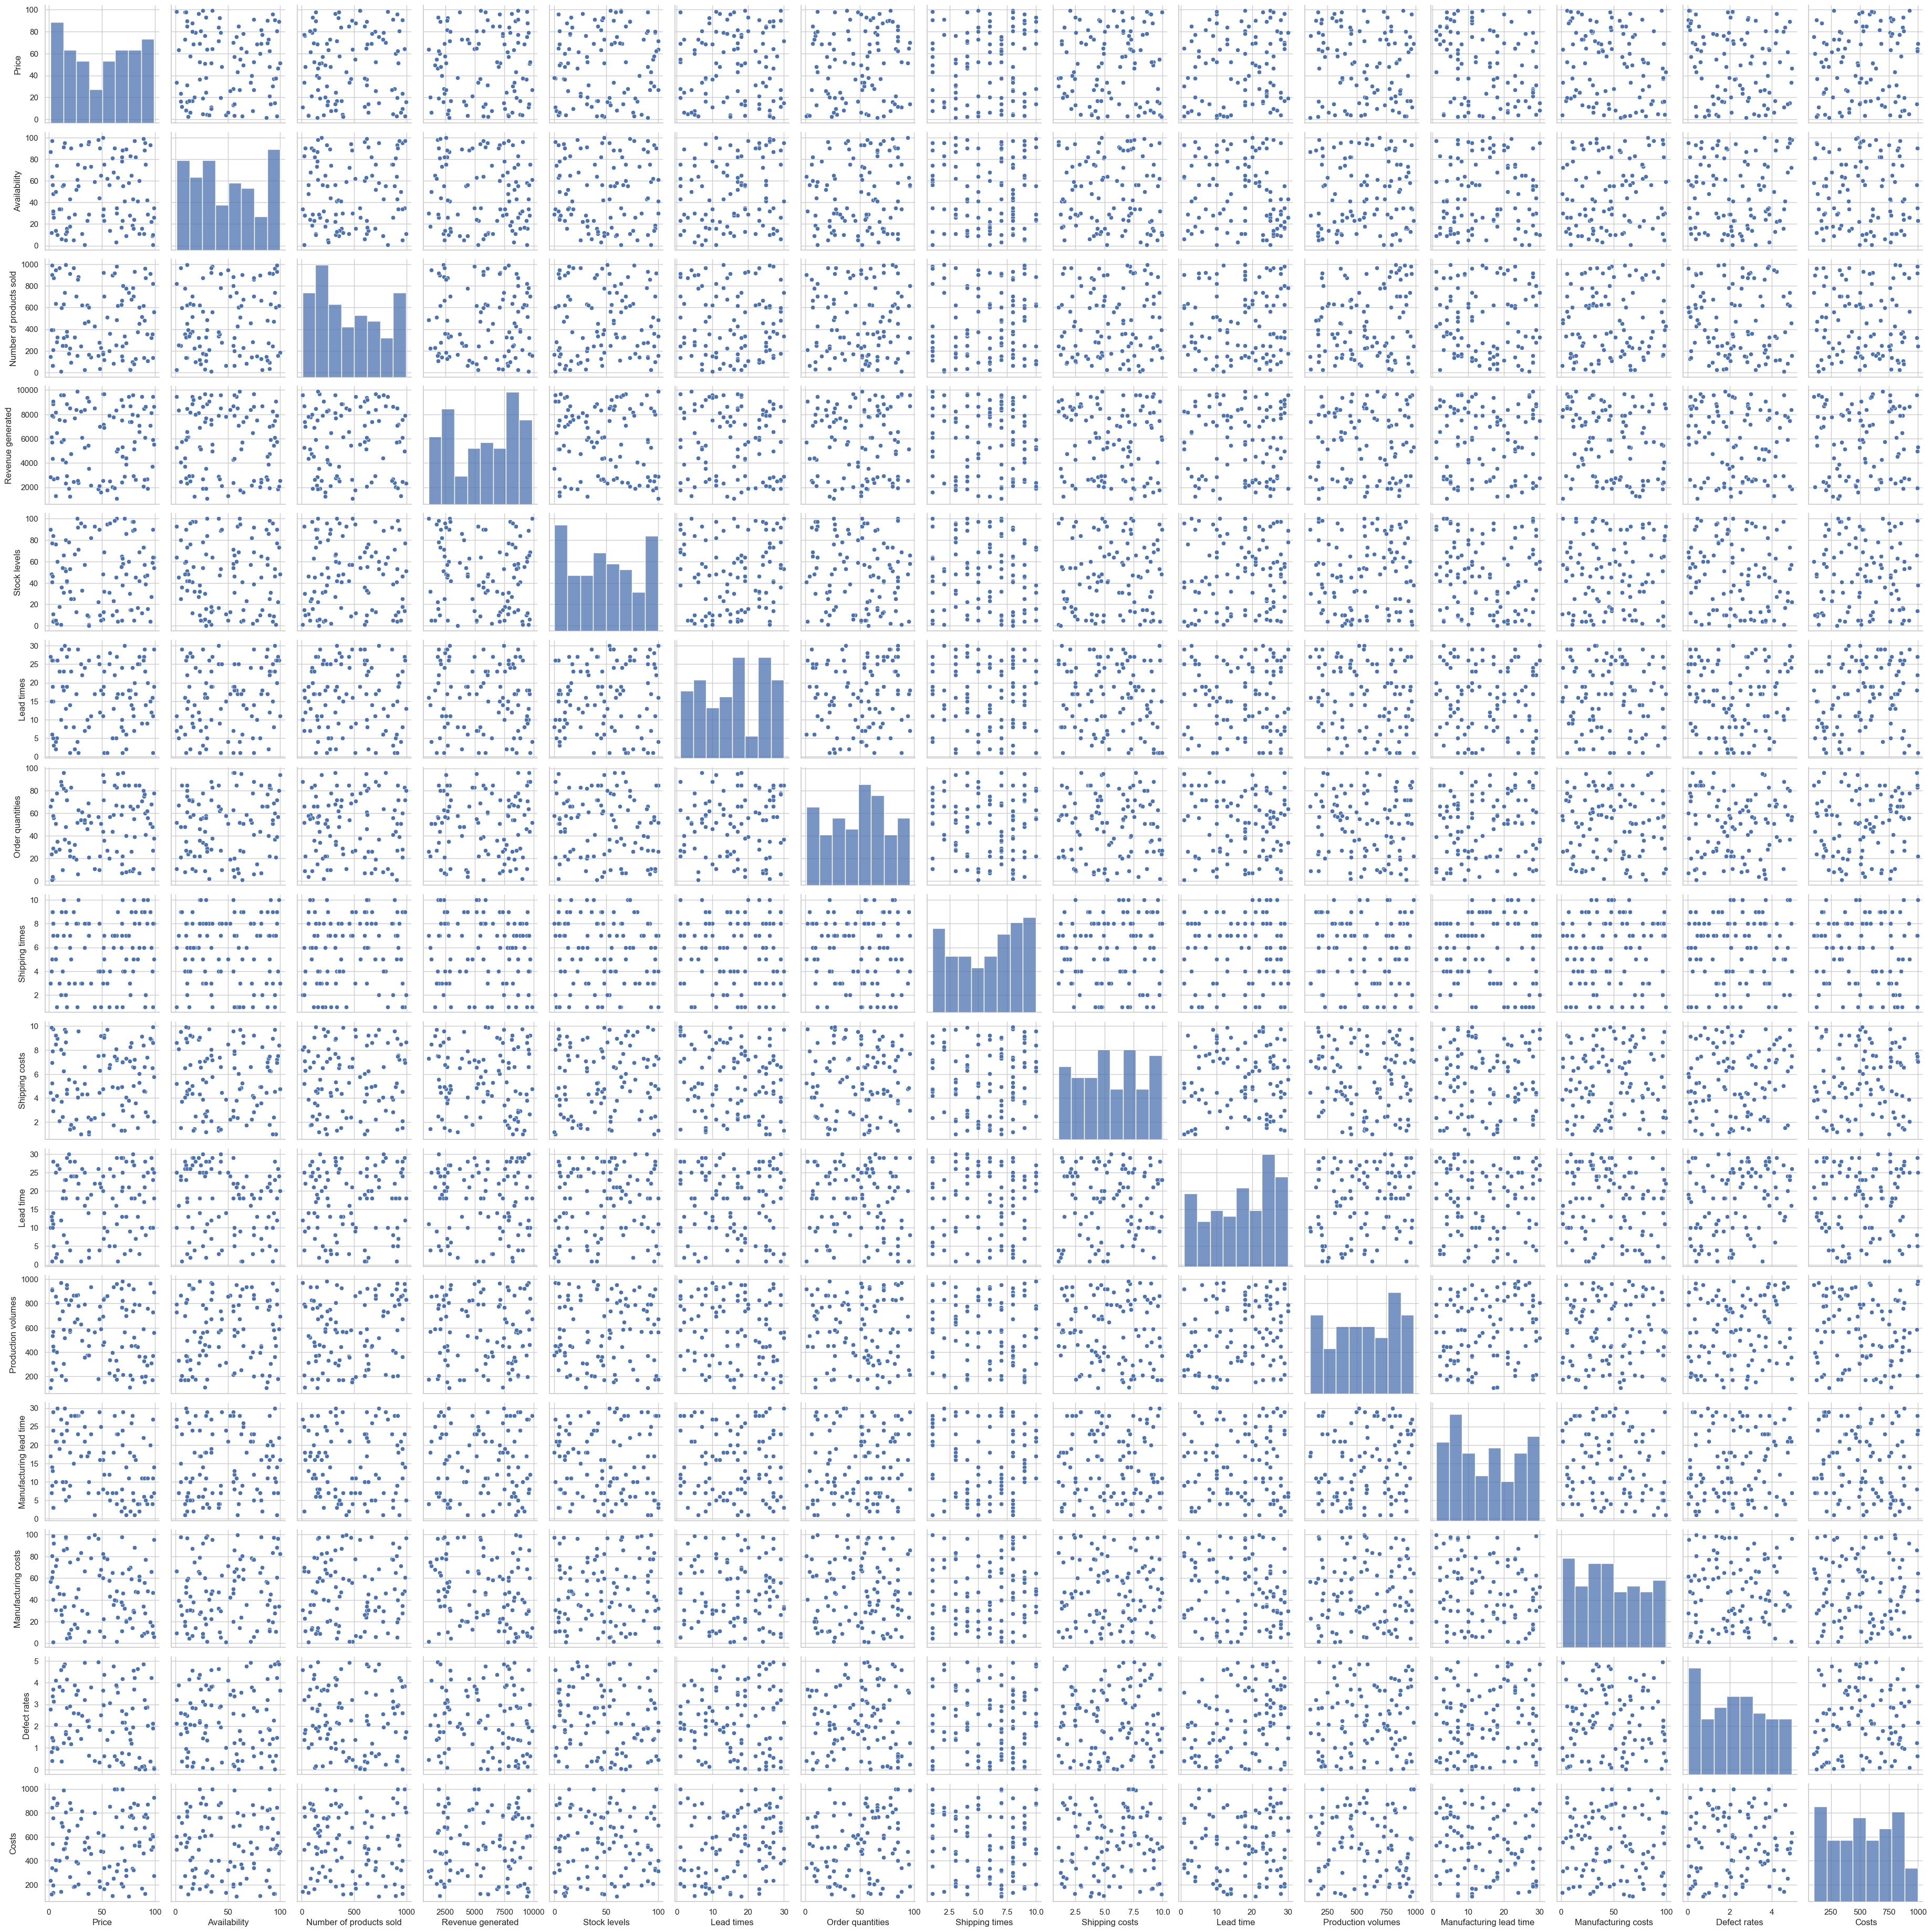

In [84]:
sns.pairplot(inventory_stock_data.select_dtypes(include=['number']))

In [85]:
numerical_columns_sales

Index(['Days for shipping (real)', 'Days for shipment (scheduled)',
       'Benefit per order', 'Sales per customer', 'Late_delivery_risk',
       'Category Id', 'Customer Id', 'Customer Zipcode', 'Department Id',
       'Latitude', 'Longitude', 'Order Customer Id', 'Order Id',
       'Order Item Cardprod Id', 'Order Item Discount',
       'Order Item Discount Rate', 'Order Item Id', 'Order Item Product Price',
       'Order Item Profit Ratio', 'Order Item Quantity', 'Sales',
       'Order Item Total', 'Order Profit Per Order', 'Order Zipcode',
       'Product Card Id', 'Product Category Id', 'Product Price',
       'Product Status'],
      dtype='object')

In [86]:
categorical_columns_sales

Index(['Customer Country', 'Customer Email', 'Customer Password',
       'Customer Segment', 'Delivery Status', 'Department Name', 'Market',
       'Order Region', 'Order Status', 'Shipping Mode', 'Type'],
      dtype='object')

#### [Categorical-Continuous] Bivariate Analysis Distributions in Sales_Shipment_Data

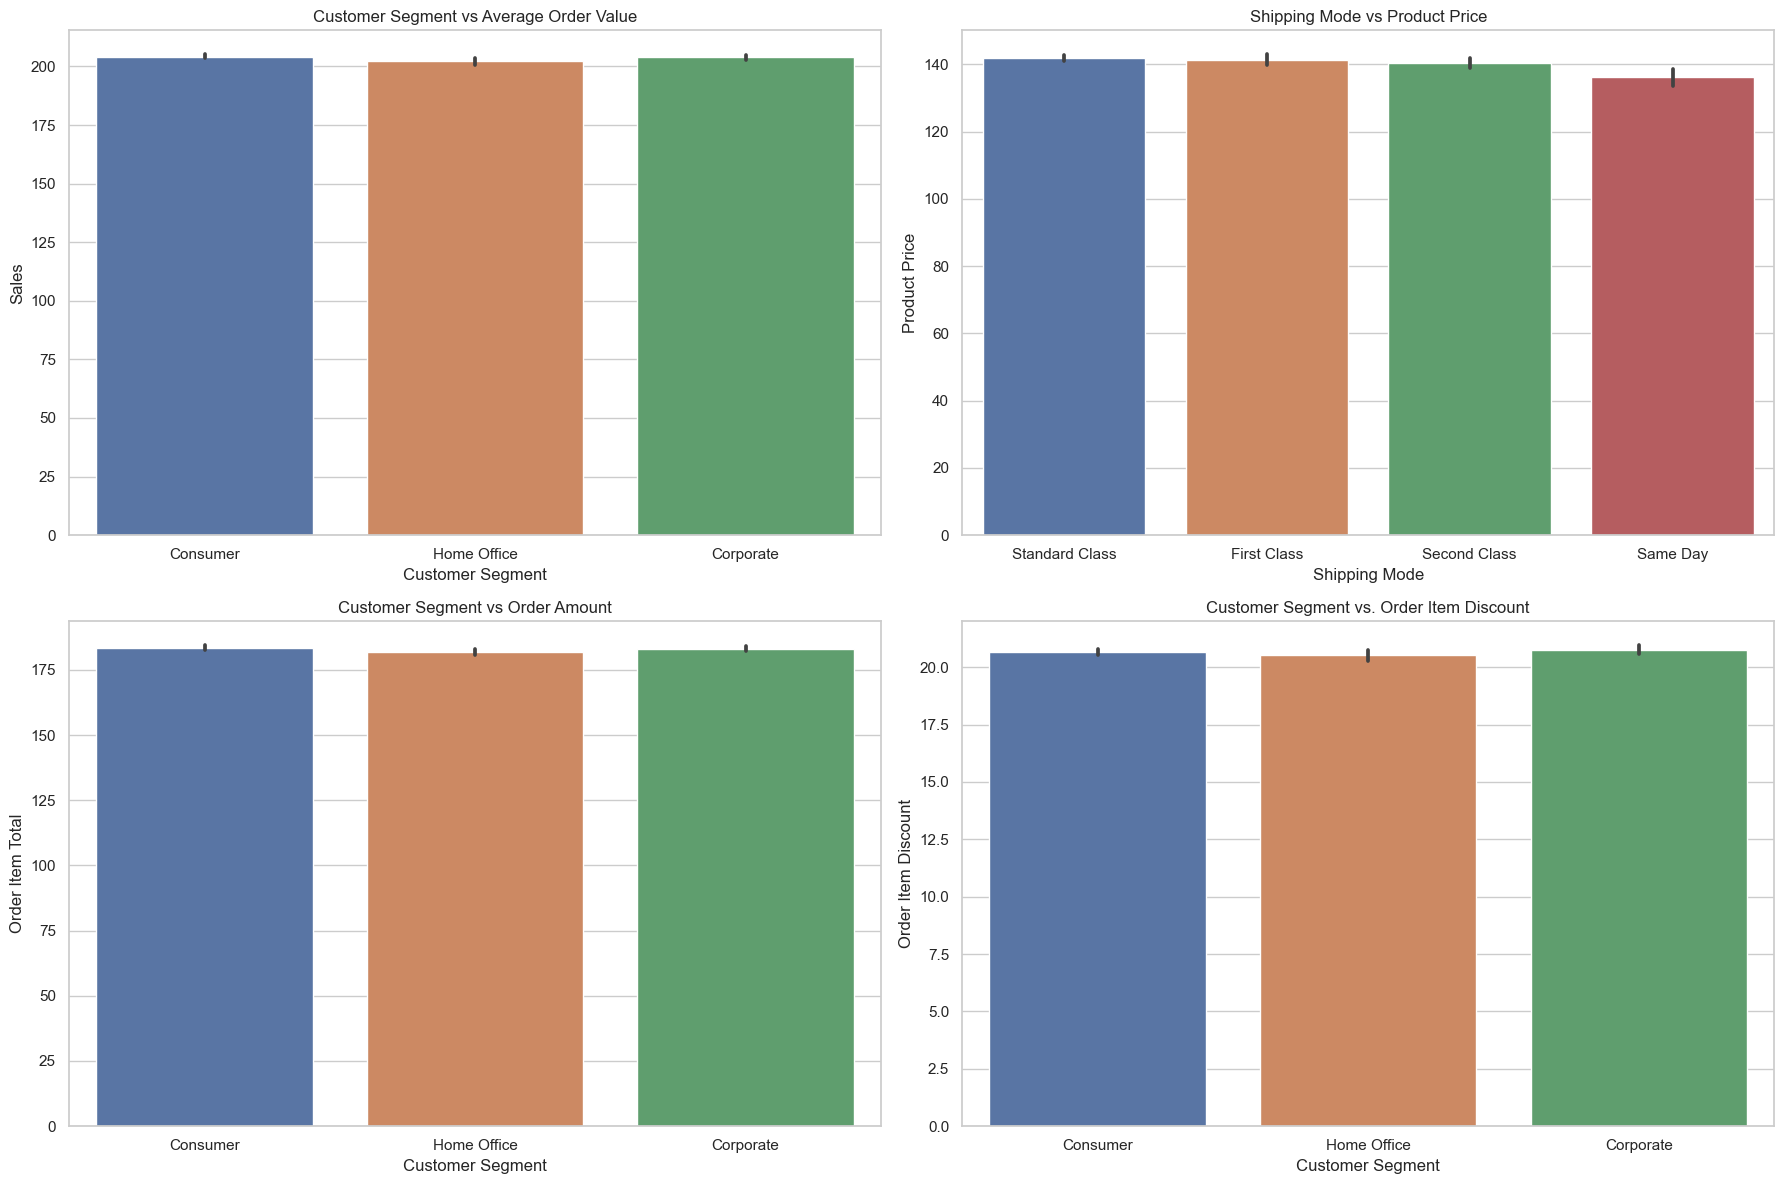

In [88]:
# Categorical-Continuous
plt.figure(figsize=(18, 12))
#fig.suptitle('Bivariate Analysis Distributions in Sales_Shipment_Data',y=1.02)
plt.subplot(2, 2, 1)
sns.barplot(x='Customer Segment', y='Sales', data=sales_shipment_data)
plt.title('Customer Segment vs Average Order Value')

plt.subplot(2, 2, 2)
sns.barplot(x='Shipping Mode', y='Product Price', data=sales_shipment_data)
plt.title('Shipping Mode vs Product Price')

plt.subplot(2, 2, 3)
sns.barplot(x='Customer Segment', y='Order Item Total', data=sales_shipment_data)
plt.title('Customer Segment vs Order Amount')

plt.subplot(2, 2, 4)
sns.barplot(x='Customer Segment', y='Order Item Discount', data=sales_shipment_data)
plt.title('Customer Segment vs. Order Item Discount')

plt.tight_layout()
plt.show()

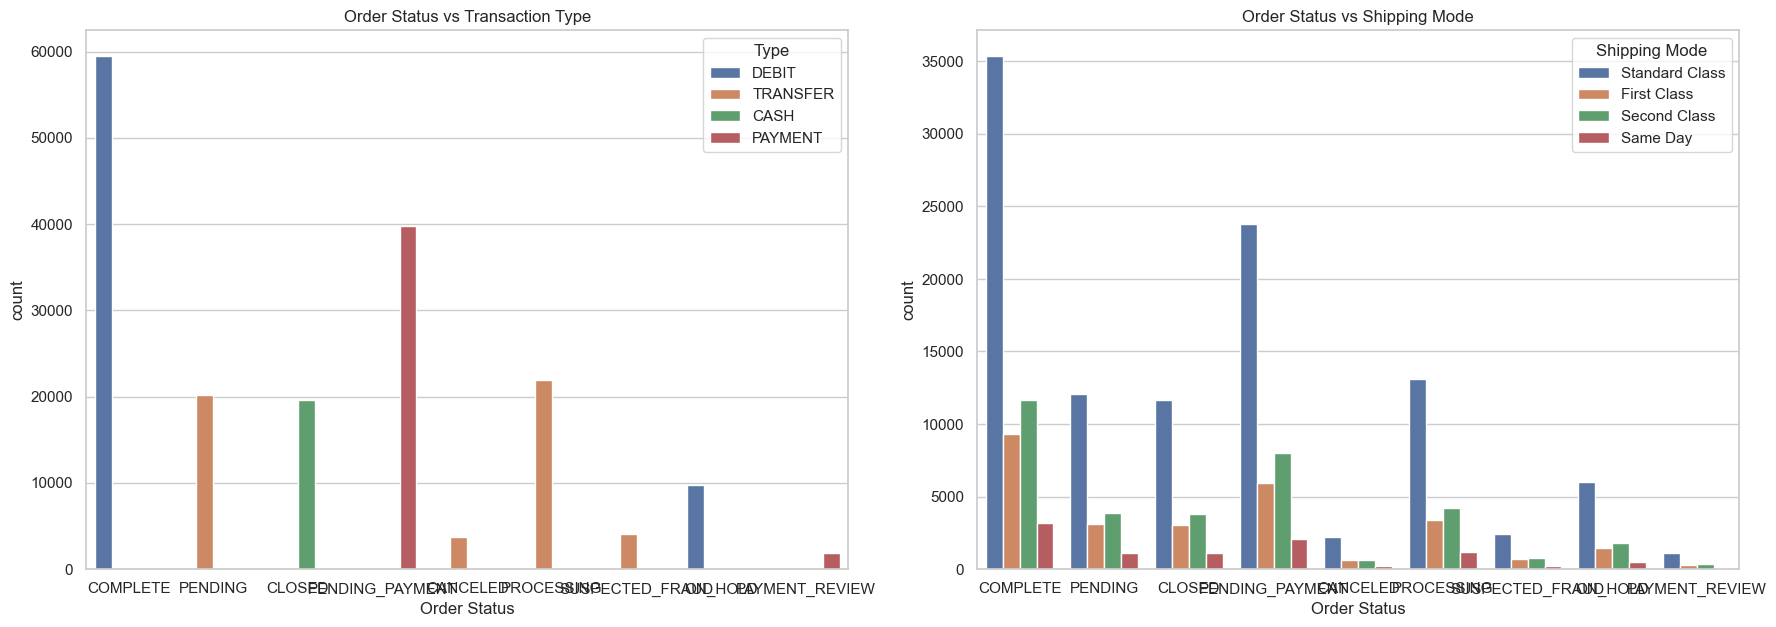

In [89]:
# Categorical-Categorical: Association between customer segment and product category purchased
plt.figure(figsize=(18, 12))

plt.subplot(2, 2, 1)
sns.countplot(x='Order Status', hue='Type', data=sales_shipment_data)
plt.title('Order Status vs Transaction Type')

plt.subplot(2, 2, 2)
sns.countplot(x='Order Status', hue='Shipping Mode', data=sales_shipment_data)
plt.title('Order Status vs Shipping Mode')

plt.tight_layout()
plt.show()

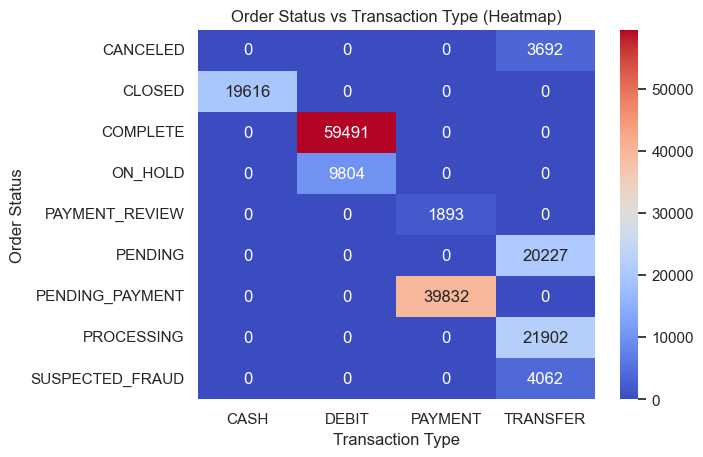

In [90]:
# Cross-tabulation between order status and payment method
cross_tab_status_payment = pd.crosstab(sales_shipment_data['Order Status'], sales_shipment_data['Type'])
sns.heatmap(cross_tab_status_payment, annot=True, cmap='coolwarm', fmt='d')
plt.title('Order Status vs Transaction Type (Heatmap)')
plt.xlabel('Transaction Type')
plt.ylabel('Order Status')
plt.show()

> Observations:
>* Need to fix/Rename the column names
>* Need to change the data types of some variables 

In [112]:
sales_shipment_data.head(2)


Type  Days for shipping (real)  Days for shipment (scheduled)  \
0     DEBIT                         3                              4   
1  TRANSFER                         5                              4   

   Benefit per order  Sales per customer   Delivery Status  \
0          91.250000          314.640015  Advance shipping   
1        -249.089996          311.359985     Late delivery   

   Late_delivery_risk  Category Id   Category Name Customer City  \
0                   0           73  Sporting Goods        Caguas   
1                   1           73  Sporting Goods        Caguas   

  Customer Country Customer Email Customer Fname  Customer Id Customer Lname  \
0      Puerto Rico      XXXXXXXXX          Cally        20755       Holloway   
1      Puerto Rico      XXXXXXXXX          Irene        19492           Luna   

  Customer Password Customer Segment Customer State           Customer Street  \
0         XXXXXXXXX         Consumer             PR  5365 Noble Nectar Island   
1         XXXXXXXXX         Consumer             PR          2679 Rustic Loop   

   Customer Zipcode  Department Id Department Name   Latitude  Longitude  \
0             725.0              2         Fitness  18.251453 -66.037056   
1             725.0              2         Fitness  18.279451 -66.037064   

         Market Order City Order Country  Order Customer Id  \
0  Pacific Asia     Bekasi     Indonesia              20755   
1  Pacific Asia    Bikaner         India              19492   

  order date (DateOrders)  Order Id  Order Item Cardprod Id  \
0         1/31/2018 22:56     77202                    1360   
1         1/13/2018 12:27     75939                    1360   

   Order Item Discount  Order Item Discount Rate  Order Item Id  \
0            13.110000                      0.04         180517   
1            16.389999                      0.05         179254   

   Order Item Product Price  Order Item Profit Ratio  Order Item Quantity  \
0                    327.75                     0.29                    1   
1                    327.75                    -0.80                    1   

    Sales  Order Item Total  Order Profit Per Order    Order Region  \
0  327.75        314.640015               91.250000  Southeast Asia   
1  327.75        311.359985             -249.089996      South Asia   

       Order State Order Status  Order Zipcode  Product_Card_Id  \
0  Java Occidental     COMPLETE            NaN             1360   
1         Rajastán      PENDING            NaN             1360   

   Product Category Id  Product Name  Product Price  Product Status  \
0                   73  Smart watch          327.75               0   
1                   73  Smart watch          327.75               0   

  shipping date (DateOrders)   Shipping Mode  
0             2/3/2018 22:56  Standard Class  
1            1/18/2018 12:27  Standard Class

In [111]:
inventory_stock_data.head(2)

Product type   SKU      Price  Availability  Number of products sold  \
0     haircare  SKU0  69.808006            55                      802   
1     skincare  SKU1  14.843523            95                      736   

   Revenue generated Customer demographics  Stock levels  Lead times  \
0        8661.996792            Non-binary            58           7   
1        7460.900065                Female            53          30   

   Order quantities  Shipping times Shipping carriers  Shipping costs  \
0                96               4         Carrier B        2.956572   
1                37               2         Carrier A        9.716575   

  Supplier name Location  Lead time  Production volumes  \
0    Supplier 3   Mumbai         29                 215   
1    Supplier 3   Mumbai         23                 517   

   Manufacturing lead time  Manufacturing costs Inspection results  \
0                       29            46.279879            Pending   
1                       30            33.616769            Pending   

   Defect rates Transportation modes   Routes       Costs  Product_Id  
0      0.226410                 Road  Route B  187.752075         743  
1      4.854068                 Road  Route B  503.065579         572

In [113]:
sales_inventory=pd.merge(left=sales_shipment_data, right=inventory_stock_data,
        left_on='Product_Card_Id', right_on='Product_Id',
        how='left')

In [114]:
# Create a new flag variable 'Late Delivery Risk'
sales_inventory['Late Delivery Risk'] = np.where(
    sales_inventory['Days for shipping (real)'] <= sales_inventory['Days for shipment (scheduled)'],
    'Not Late','Late')

In [115]:
# Rename variables (replace space with '_')
sales_inventory.columns = sales_inventory.columns.str.replace(' ', '_')

In [116]:
# Apply the convert_date_y2Y function to 'order_date_(DateOrders)' and 'shipping_date_(DateOrders)'
sales_inventory['order_date_(DateOrders)'] = sales_inventory['order_date_(DateOrders)'].apply(convert_date_y2Y)
sales_inventory['shipping_date_(DateOrders)'] = sales_inventory['shipping_date_(DateOrders)'].apply(convert_date_y2Y)

# Convert 'order_date_(DateOrders)' and 'shipping_date_(DateOrders)' to datetime format
sales_inventory['order_date_(DateOrders)'] = pd.to_datetime(sales_inventory['order_date_(DateOrders)'], format='%m/%d/%Y %H:%M')
sales_inventory['shipping_date_(DateOrders)'] = pd.to_datetime(sales_inventory['shipping_date_(DateOrders)'], format='%m/%d/%Y %H:%M')

In [117]:
sales_inventory.isna().sum()[sales_inventory.isna().sum()>0]

Customer_Lname                  8
Customer_Zipcode                4
Order_Zipcode              210249
Product_type                88743
SKU                         88743
Price                       88743
Availability                88743
Number_of_products_sold     88743
Revenue_generated           88743
Customer_demographics       88743
Stock_levels                88743
Lead_times                  88743
Order_quantities            88743
Shipping_times              88743
Shipping_carriers           88743
Shipping_costs              88743
Supplier_name               88743
Location                    88743
Lead_time                   88743
Production_volumes          88743
Manufacturing_lead_time     88743
Manufacturing_costs         88743
Inspection_results          88743
Defect_rates                88743
Transportation_modes        88743
Routes                      88743
Costs                       88743
Product_Id                  88743
dtype: int64

> we have missing values in Customer_Lname & Customer_Zipcode

In [118]:
sales_inventory['Customer_Zipcode'] = sales_inventory['Customer_Zipcode'].fillna('unknown')

In [119]:
sales_inventory['Customer_Lname']=sales_inventory['Customer_Lname'].fillna('unknown')

In [120]:
sales_inventory.isna().sum()[sales_inventory.isna().sum()>0]

Order_Zipcode              210249
Product_type                88743
SKU                         88743
Price                       88743
Availability                88743
Number_of_products_sold     88743
Revenue_generated           88743
Customer_demographics       88743
Stock_levels                88743
Lead_times                  88743
Order_quantities            88743
Shipping_times              88743
Shipping_carriers           88743
Shipping_costs              88743
Supplier_name               88743
Location                    88743
Lead_time                   88743
Production_volumes          88743
Manufacturing_lead_time     88743
Manufacturing_costs         88743
Inspection_results          88743
Defect_rates                88743
Transportation_modes        88743
Routes                      88743
Costs                       88743
Product_Id                  88743
dtype: int64

In [122]:
numerical_columns = sales_inventory.select_dtypes(include='number').columns
categorical_columns = sales_inventory.select_dtypes(include='object').columns

In [123]:
# Impute missing values with mean for numerical columns
sales_inventory[numerical_columns] = sales_inventory[numerical_columns].fillna(sales_inventory[numerical_columns].mean())

# Impute missing values with mode for categorical columns
sales_inventory[categorical_columns] = sales_inventory[categorical_columns].fillna(sales_inventory.mode().iloc[0])

In [121]:
# Create columns for week, month, year, and quarter
sales_inventory['week'] = sales_inventory['order_date_(DateOrders)'].dt.isocalendar().week
sales_inventory['month'] = sales_inventory['order_date_(DateOrders)'].dt.month
sales_inventory['year'] = sales_inventory['order_date_(DateOrders)'].dt.year
sales_inventory['quarter'] = sales_inventory['order_date_(DateOrders)'].dt.quarter

---

Caclulate high level metrics like, total sale value, total sale units, inventory value, inventory quantity, profit value, number of distinct products, number of distinct categories, number of distinct products etc

In [125]:
# Total Sale Value
total_sale_value = sales_inventory['Sales'].sum()

# Total Sale Units
total_sale_units = sales_inventory['Order_Item_Quantity'].sum()

# Inventory Value
inventory_value = sales_inventory['Stock_levels'] * sales_inventory['Product_Price']
total_inventory_value = inventory_value.sum()

# Inventory Quantity
total_inventory_quantity = sales_inventory['Stock_levels'].sum()

# Profit Value
total_profit_value = sales_inventory['Order_Profit_Per_Order'].sum()

# Number of Distinct Products
distinct_products = sales_inventory['Product_Id'].nunique()

# Number of Distinct Categories
distinct_categories = sales_inventory['Category_Name'].nunique()

# Number of Distinct Customers
distinct_customers = sales_inventory['Customer_Id'].nunique()

In [126]:
# Display the results
print('-------- -------- ---------- -------')
print(f"Total Sale Value: {total_sale_value:.2f}")
print('-------- -------- ---------- -------')
print(f"Total Sale Units: {total_sale_units}")
print('-------- -------- ---------- -------')
print(f"Total Inventory Value: {total_inventory_value:.2f}")
print('-------- -------- ---------- -------')
print(f"Total Inventory Quantity: {total_inventory_quantity}")
print('-------- -------- ---------- -------')
print(f"Total Profit Value: {total_profit_value:.2f}")
print('-------- -------- ---------- -------')
print(f"Number of Distinct Products: {distinct_products}")
print('-------- -------- ---------- -------')
print(f"Number of Distinct Categories: {distinct_categories}")
print('-------- -------- ---------- -------')
print(f"Number of Distinct Customers: {distinct_customers}")
print('-------- -------- ---------- -------')

-------- -------- ---------- -------
Total Sale Value: 46802619.70
-------- -------- ---------- -------
Total Sale Units: 480522
-------- -------- ---------- -------
Total Inventory Value: 1272192823.33
-------- -------- ---------- -------
Total Inventory Quantity: 8937351.674794232
-------- -------- ---------- -------
Total Profit Value: 5029479.20
-------- -------- ---------- -------
Number of Distinct Products: 65
-------- -------- ---------- -------
Number of Distinct Categories: 50
-------- -------- ---------- -------
Number of Distinct Customers: 20652
-------- -------- ---------- -------


In [127]:
# Status of Orders - Number of Orders by Current Status
order_status_counts = sales_inventory['Order_Status'].value_counts()

# Display the status of orders
print("Status of Orders - Number of Orders by Current Status:")
print('-------- -------- ---------- ------- -------- --------')
print(order_status_counts)

Status of Orders - Number of Orders by Current Status:
-------- -------- ---------- ------- -------- --------
COMPLETE           80483
PENDING_PAYMENT    53678
PROCESSING         29457
PENDING            27414
CLOSED             26665
ON_HOLD            13271
SUSPECTED_FRAUD     5524
CANCELED            5034
PAYMENT_REVIEW      2491
Name: Order_Status, dtype: int64


In [128]:
# Status of Delivery of Orders - Number of Orders by Each Type of Delivery Status
delivery_status_counts = sales_inventory['Delivery_Status'].value_counts()

# Display the status of delivery for orders
print("Count of Orders Delivery Status:")
print('-------- -------- -------------')
print(delivery_status_counts)


Count of Orders Delivery Status:
-------- -------- -------------
Late delivery        133599
Advance shipping      56319
Shipping on time      43541
Shipping canceled     10558
Name: Delivery_Status, dtype: int64


Late Delivery Risk</b> by time (by each week, month, year, quarter)

In [129]:
# Calculate Late Delivery Risk by time
late_delivery_risk_by_week = sales_inventory.groupby('week')['Late_Delivery_Risk'].value_counts().unstack()
late_delivery_risk_by_month = sales_inventory.groupby('month')['Late_Delivery_Risk'].value_counts().unstack()
late_delivery_risk_by_year = sales_inventory.groupby('year')['Late_Delivery_Risk'].value_counts().unstack()
late_delivery_risk_by_quarter = sales_inventory.groupby('quarter')['Late_Delivery_Risk'].value_counts().unstack()

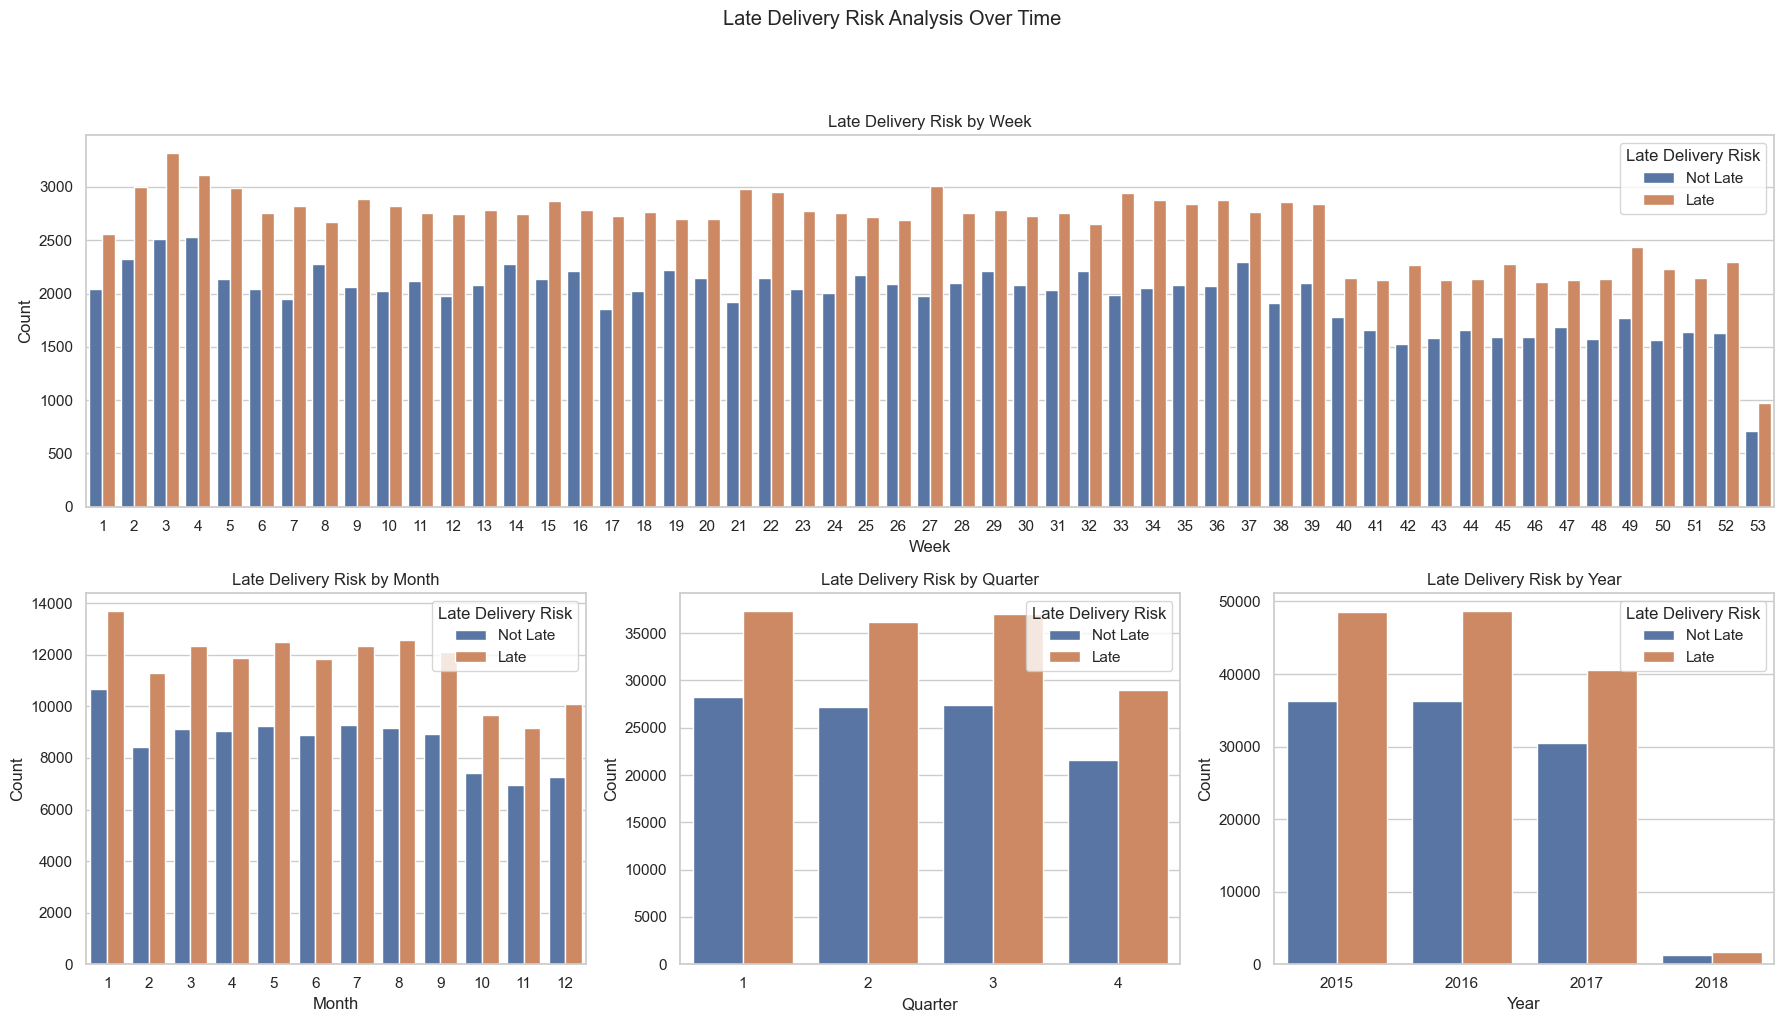

In [130]:
# Set up the style for seaborn plots
sns.set(style="whitegrid")

# Create subplots
fig = plt.figure(figsize=(18, 10))
fig.suptitle('Late Delivery Risk Analysis Over Time', y=1.02)

# Subplot 1: Late Delivery Risk by Week
sub1 = fig.add_subplot(2, 1, 1)
sns.countplot(x='week', hue='Late_Delivery_Risk', data=sales_inventory, ax=sub1)
sub1.set_title('Late Delivery Risk by Week')
sub1.set_xlabel('Week')
sub1.set_ylabel('Count')
sub1.legend(title='Late Delivery Risk')

# Subplots 2-4: Late Delivery Risk by Month, Quarter, and Year
sub2 = fig.add_subplot(2, 3, 4)
sns.countplot(x='month', hue='Late_Delivery_Risk', data=sales_inventory, ax=sub2)
sub2.set_title('Late Delivery Risk by Month')
sub2.set_xlabel('Month')
sub2.set_ylabel('Count')
sub2.legend(title='Late Delivery Risk')

sub3 = fig.add_subplot(2, 3, 5)
sns.countplot(x='quarter', hue='Late_Delivery_Risk', data=sales_inventory, ax=sub3)
sub3.set_title('Late Delivery Risk by Quarter')
sub3.set_xlabel('Quarter')
sub3.set_ylabel('Count')
sub3.legend(title='Late Delivery Risk')

sub4 = fig.add_subplot(2, 3, 6)
sns.countplot(x='year', hue='Late_Delivery_Risk', data=sales_inventory, ax=sub4)
sub4.set_title('Late Delivery Risk by Year')
sub4.set_xlabel('Year')
sub4.set_ylabel('Count')
sub4.legend(title='Late Delivery Risk')

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.97])  # Adjust the suptitle position
plt.show()

Order Item qty by time (by each week, month, year, quarter)

In [131]:
Order_Item_Quantity_by_week = sales_inventory.groupby('week')['Order_Item_Quantity'].sum().reset_index()
Order_Item_Quantity_by_month = sales_inventory.groupby('month')['Order_Item_Quantity'].sum().reset_index()
Order_Item_Quantity_by_year = sales_inventory.groupby('year')['Order_Item_Quantity'].sum().reset_index()
Order_Item_Quantity_by_quarter = sales_inventory.groupby('quarter')['Order_Item_Quantity'].sum().reset_index()

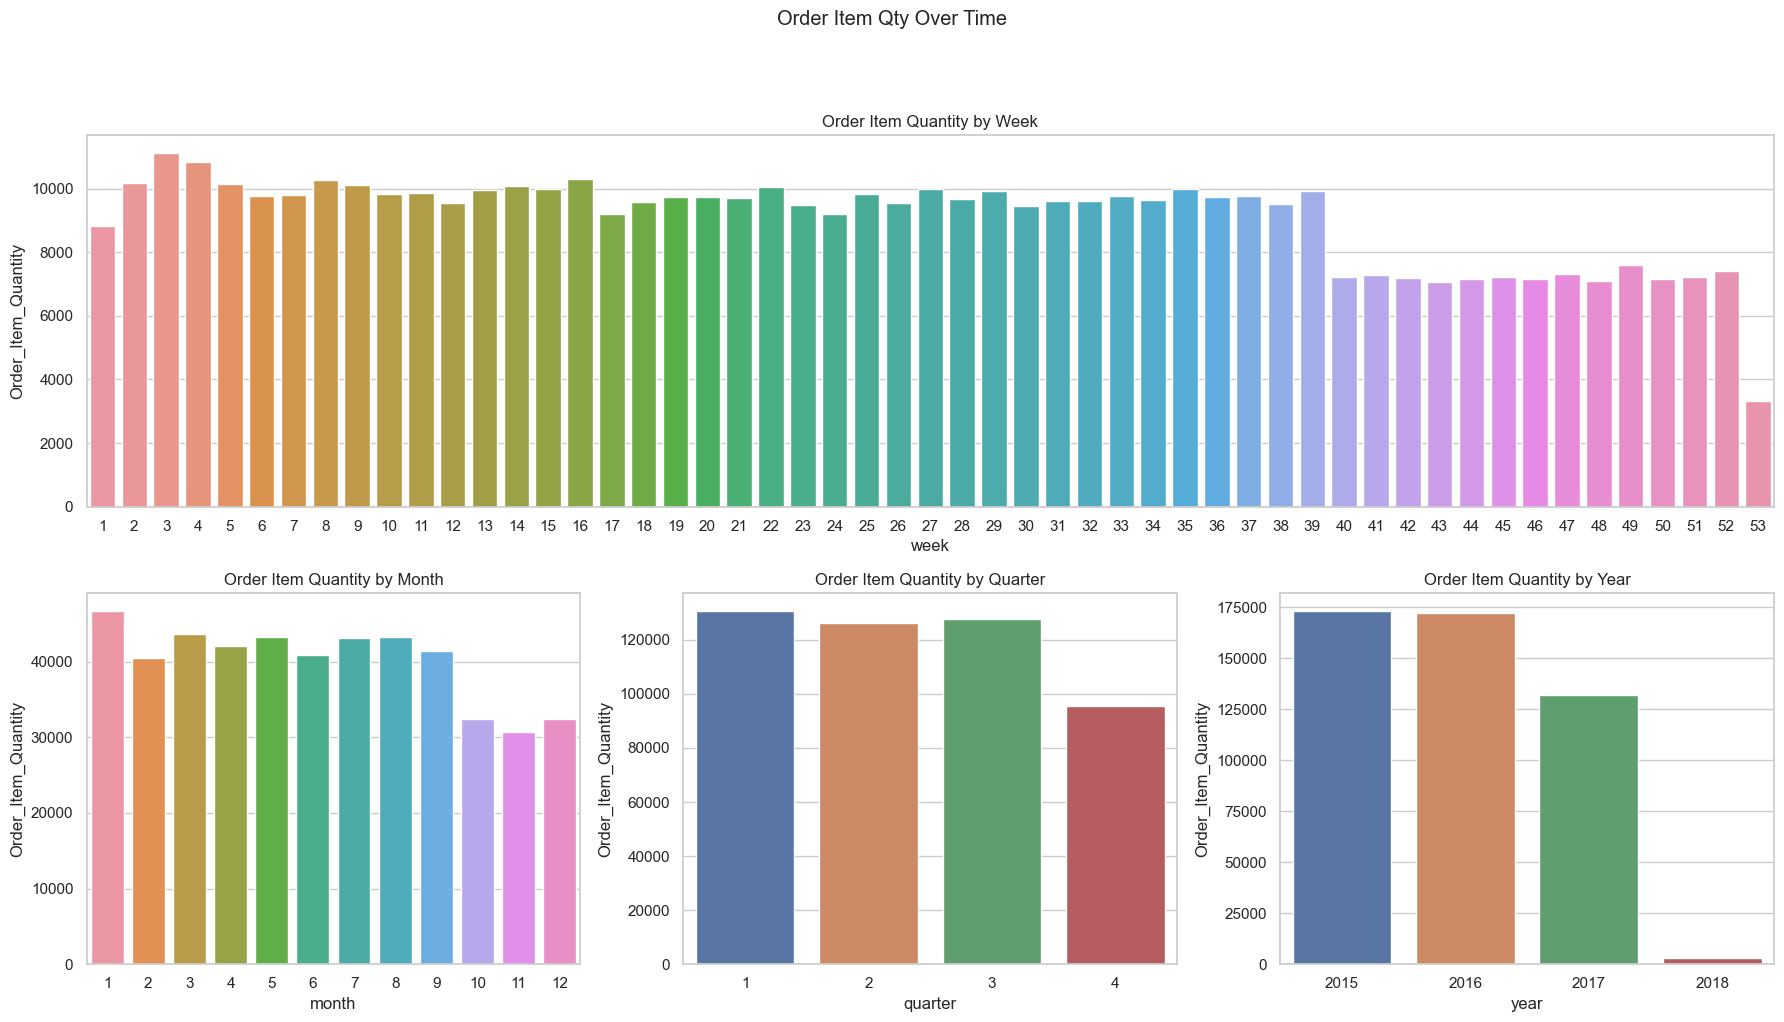

In [132]:
# Set up the style for seaborn plots
sns.set(style="whitegrid")

# Create subplots
fig = plt.figure(figsize=(18, 10))
fig.suptitle('Order Item Qty Over Time', y=1.02)


# Subplot 1: Order Item Quantity by Week
sub1 = fig.add_subplot(2, 1, 1)
sns.barplot(Order_Item_Quantity_by_week, x='week', y='Order_Item_Quantity',ax=sub1)
sub1.set_title('Order Item Quantity by Week')

# Subplot 2: Order Item Quantity by Month
sub2 = fig.add_subplot(2, 3, 4)
sns.barplot(x='month', y='Order_Item_Quantity', data=Order_Item_Quantity_by_month, ax=sub2)
sub2.set_title('Order Item Quantity by Month')

# Subplot 3: Order Item Quantity by Quarter
sub3 = fig.add_subplot(2, 3, 5)
sns.barplot(x='quarter', y='Order_Item_Quantity', data=Order_Item_Quantity_by_quarter, ax=sub3)
sub3.set_title('Order Item Quantity by Quarter')

# Subplot 4: Order Item Quantity by Year
sub4 = fig.add_subplot(2, 3, 6)
sns.barplot(x='year', y='Order_Item_Quantity', data=Order_Item_Quantity_by_year, ax=sub4)
sub4.set_title('Order Item Quantity by Year')

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.97])  # Adjust the suptitle position
plt.show()

[Matplotlib showing x-tick labels overlapping]("https://stackoverflow.com/questions/26700598/matplotlib-showing-x-tick-labels-overlapping")

Sales units/value  by time (by each week, month, year, quarter)

> how many units they sold? & its value

In [133]:
# Calculate Avg units sold and Avg value
avg_sales_by_week = sales_inventory.groupby('week').agg(mean_units=('Order_Item_Quantity', 'mean'),
                                                         mean_value=('Sales', 'mean')).reset_index()

avg_sales_by_month = sales_inventory.groupby('month').agg(mean_units=('Order_Item_Quantity', 'mean'),
                                                           mean_value=('Sales', 'mean')).reset_index()

avg_sales_by_quarter = sales_inventory.groupby('quarter').agg(mean_units=('Order_Item_Quantity', 'mean'),
                                                               mean_value=('Sales', 'mean')).reset_index()

avg_sales_by_year = sales_inventory.groupby('year').agg(mean_units=('Order_Item_Quantity', 'mean'),
                                                         mean_value=('Sales', 'mean')).reset_index()

In [134]:
avg_sales_by_week.head()

week  mean_units  mean_value
0     1    1.913733  197.556949
1     2    1.911003  185.374602
2     3    1.906502  162.467951
3     4    1.920432  172.433362
4     5    1.979711  190.038379

Text(0.5, 0, 'Yearly Avg Sales')

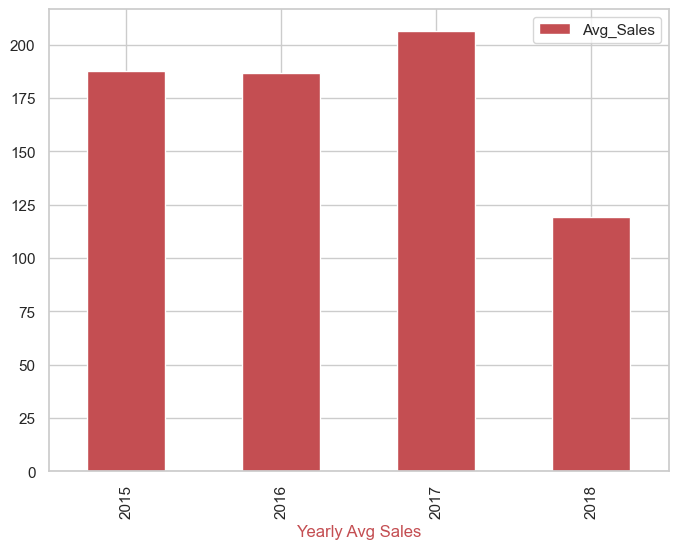

In [135]:
sales_inventory.groupby('year').agg(Avg_Sales=('Sales', 'mean')).plot(kind='bar',figsize=(8, 6),color='r')
plt.xlabel('Yearly Avg Sales',c='r',fontsize=12)

In [136]:
avg_sales_by_month.head()

month  mean_units  mean_value
0      1    1.916660  179.599866
1      2    2.049432  188.757411
2      3    2.032437  186.525538
3      4    2.011988  187.938883
4      5    1.993739  189.775024

> how many orders are in profit in time & what is the sum of that value

In [137]:
# Profit Orders/Value by Time
prof_ord = sales_inventory[sales_inventory['Order_Profit_Per_Order'] > 0]
profit_orders_value_by_week = prof_ord.groupby('week').agg(cnt=('Order_Id',pd.Series.nunique), 
                                                           net=('Sales',np.sum))
profit_orders_value_by_month = prof_ord.groupby('month').agg(cnt=('Order_Id',pd.Series.nunique), 
                                                           net=('Sales',np.sum))
profit_orders_value_by_quarter = prof_ord.groupby('quarter').agg(cnt=('Order_Id',pd.Series.nunique), 
                                                           net=('Sales',np.sum))
profit_orders_value_by_year = prof_ord.groupby('year').agg(cnt=('Order_Id',pd.Series.nunique), 
                                                           net=('Sales',np.sum))

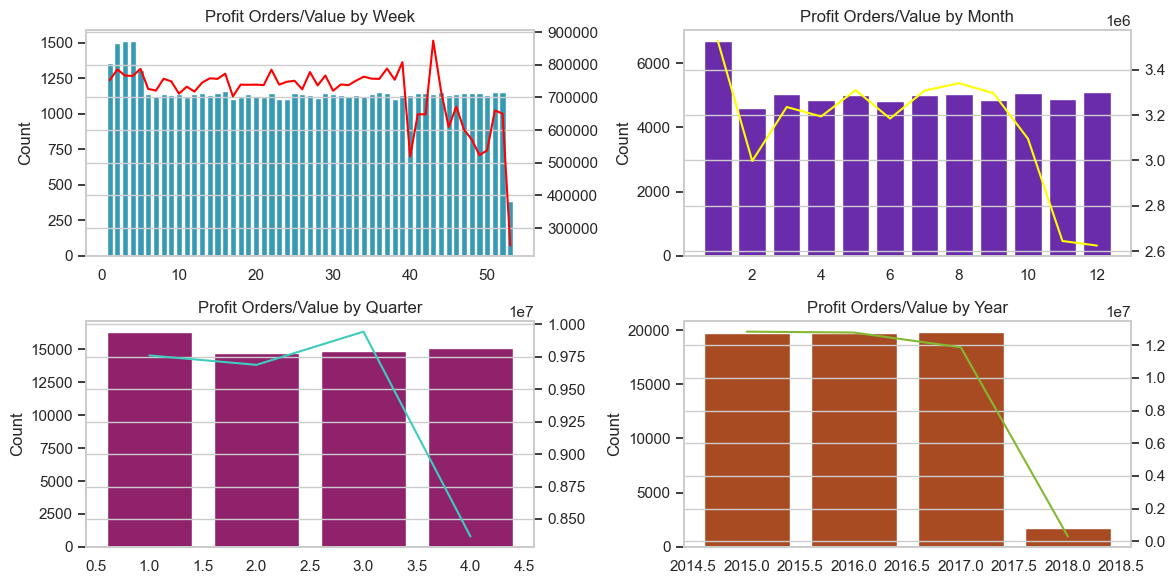

In [138]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 6))

# Plot by Week
axes[0, 0].bar(profit_orders_value_by_week.index, profit_orders_value_by_week['cnt'], label='Count', color='#369ab5')
axes[0, 0].set_ylabel('Count')
axes[0, 0].twinx().plot(profit_orders_value_by_week.index, profit_orders_value_by_week['net'], 'red', label='Net Sales')
axes[0, 0].set_title('Profit Orders/Value by Week')
axes[0, 0].grid(False)

# Plot by Month
axes[0, 1].bar(profit_orders_value_by_month.index, profit_orders_value_by_month['cnt'], label='Count',color='#6a2cab')
axes[0, 1].set_ylabel('Count')
axes[0, 1].twinx().plot(profit_orders_value_by_month.index, profit_orders_value_by_month['net'], 'yellow', label='Net Sales')
axes[0, 1].set_title('Profit Orders/Value by Month')
axes[0, 1].grid(False)

# Plot by Quarter
axes[1, 0].bar(profit_orders_value_by_quarter.index, profit_orders_value_by_quarter['cnt'], label='Count', color='#8f226b')
axes[1, 0].set_ylabel('Count')
axes[1, 0].twinx().plot(profit_orders_value_by_quarter.index, profit_orders_value_by_quarter['net'], '#3fccbc', label='Net Sales')
axes[1, 0].set_title('Profit Orders/Value by Quarter')
axes[1, 0].grid(False)

# Plot by Year
axes[1, 1].bar(profit_orders_value_by_year.index, profit_orders_value_by_year['cnt'], label='Count',color='#a84b23')
axes[1, 1].set_ylabel('Count')
axes[1, 1].twinx().plot(profit_orders_value_by_year.index, profit_orders_value_by_year['net'], '#84b830', label='Net Sales')
axes[1, 1].set_title('Profit Orders/Value by Year')
axes[1, 1].grid(False) 

plt.tight_layout()
plt.show()

Order profit per order  by time (by each week, month, year, quarter)

In [140]:
# Profit Orders by Time
OPPO_by_week = sales_inventory.groupby('week')['Order_Profit_Per_Order'].sum().reset_index()
OPPO_by_month = sales_inventory.groupby('month')['Order_Profit_Per_Order'].sum().reset_index()
OPPO_by_quarter = sales_inventory.groupby('quarter')['Order_Profit_Per_Order'].sum().reset_index()
OPPO_by_year = sales_inventory.groupby('year')['Order_Profit_Per_Order'].sum().reset_index()

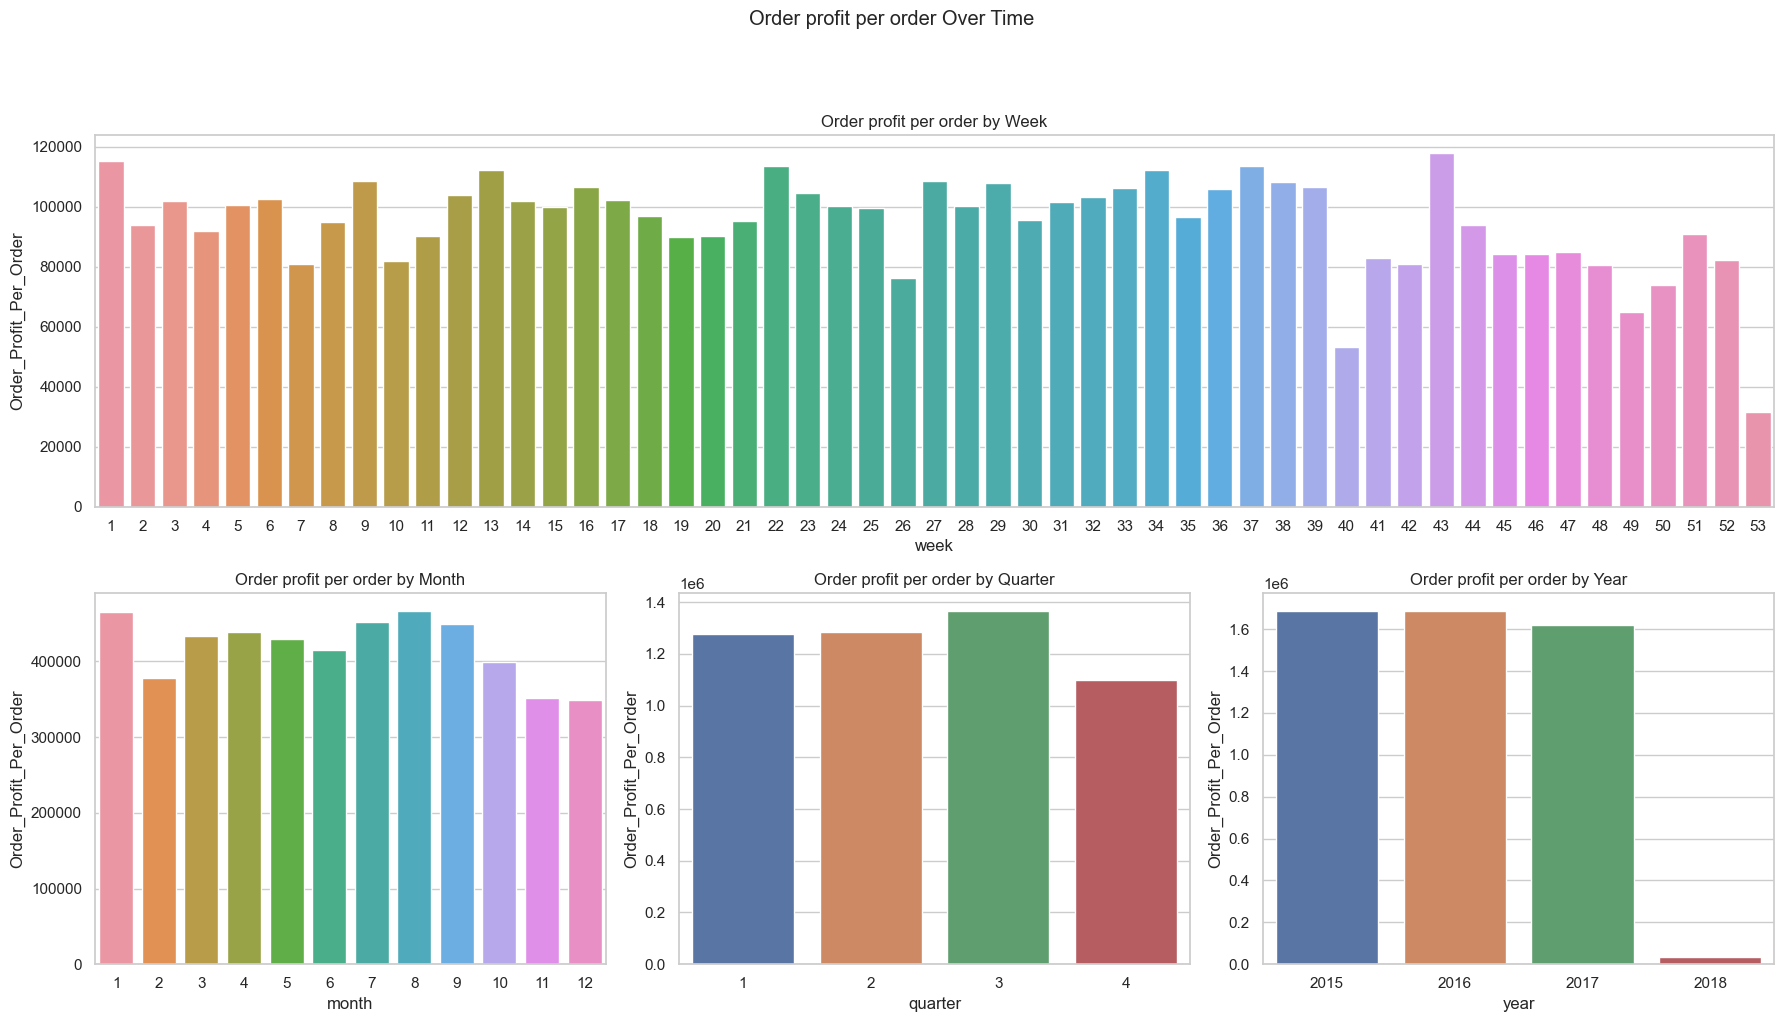

In [141]:
# Set up the style for seaborn plots
sns.set(style="whitegrid")

# Create subplots
fig = plt.figure(figsize=(18, 10))
fig.suptitle('Order profit per order Over Time', y=1.02)

# Subplot 1: Order profit per order by Week
sub1 = fig.add_subplot(2, 1, 1)
sns.barplot(x='week', y='Order_Profit_Per_Order', data=OPPO_by_week, ax=sub1)
sub1.set_title('Order profit per order by Week')

# Subplot 2: Order profit per order by Month
sub2 = fig.add_subplot(2, 3, 4)
sns.barplot(x='month', y='Order_Profit_Per_Order', data=OPPO_by_month, ax=sub2)
sub2.set_title('Order profit per order by Month')

# Subplot 3: Order profit per order by Quarter
sub3 = fig.add_subplot(2, 3, 5)
sns.barplot(x='quarter', y='Order_Profit_Per_Order', data=OPPO_by_quarter, ax=sub3)
sub3.set_title('Order profit per order by Quarter')

# Subplot 4: Order profit per order by Year
sub4 = fig.add_subplot(2, 3, 6)
sns.barplot(x='year', y='Order_Profit_Per_Order', data=OPPO_by_year, ax=sub4)
sub4.set_title('Order profit per order by Year')

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

Order count by country/state/  by time (by each week, month, year, quarter)

In [142]:
Order_count_by_country_state_by_week=sales_inventory.groupby(['Customer_Country','Customer_State','week']).agg(weekly=('Order_Id','count'))
Order_count_by_country_state_by_month =sales_inventory.groupby(['Customer_Country','Customer_State','month']).agg(weekly=('Order_Id','count'))
Order_count_by_country_state_by_quarter =sales_inventory.groupby(['Customer_Country','Customer_State','quarter']).agg(weekly=('Order_Id','count'))
Order_count_by_country_state_by_year =sales_inventory.groupby(['Customer_Country','Customer_State','year']).agg(weekly=('Order_Id','count'))

In [143]:
Order_count_by_country_state_by_quarter.sample(120)

weekly
Customer_Country Customer_State quarter        
EE. UU.          TN             3           496
                 PA             3          1343
                 FL             3          1943
                 IL             4          2147
                 MI             4          1007
...                                         ...
                 CO             1           679
Puerto Rico      PR             3         24893
EE. UU.          NM             1           352
                 AR             2            36
                 KY             3           157

[120 rows x 1 columns]

Inventory Units by each class or cluster

In [148]:
inventory_units_by_class = sales_inventory.groupby('Customer_demographics')['Stock_levels'].sum().reset_index()

In [149]:
inventory_units_by_class

Customer_demographics  Stock_levels
0                Female  7.447070e+05
1                  Male  2.536970e+06
2            Non-binary  1.959240e+05
3               Unknown  5.459751e+06

Inventory Value by Category_Name or cluster 

In [156]:
sales_inventory['Inventory_Value'] = sales_inventory['Stock_levels'] * sales_inventory['Product_Price']

sales_inventory.groupby('Category_Name')['Inventory_Value'].sum().reset_index()

Category_Name  Inventory_Value
0            Accessories     2.841406e+06
1        As Seen on  TV!     2.490315e+05
2                  Baby      1.650991e+06
3    Baseball & Softball     1.059083e+06
4             Basketball     1.291583e+06
5                 Books      9.692298e+05
6           Boxing & MMA     1.460289e+06
7                   CDs      1.120604e+05
8               Cameras      1.471842e+07
9       Camping & Hiking     1.508412e+08
10      Cardio Equipment     9.464593e+07
11   Children's Clothing     1.233995e+07
12                Cleats     7.748821e+06
13             Computers     2.428300e+07
14  Consumer Electronics     3.991908e+06
15                Crafts     8.180635e+06
16                  DVDs     2.907936e+06
17           Electronics     4.937296e+06
18               Fishing     2.538051e+08
19   Fitness Accessories     4.423035e+05
20                Garden     9.441022e+06
21        Girls' Apparel     3.407037e+06
22          Golf Apparel     2.162766e+06
23     Golf Bags & Carts     6.014246e+05
24            Golf Balls     1.722783e+06
25           Golf Gloves     2.645265e+06
26            Golf Shoes     2.369856e+06
27     Health and Beauty     3.885297e+06
28                Hockey     3.532458e+06
29    Hunting & Shooting     1.990866e+06
30  Indoor/Outdoor Games     2.411285e+07
31      Kids' Golf Clubs     2.664167e+06
32              Lacrosse     1.322284e+06
33        Men's Clothing     1.606297e+06
34        Men's Footwear     4.135213e+08
35      Men's Golf Clubs     1.611347e+06
36                 Music     4.143203e+06
37          Pet Supplies     2.366914e+06
38         Shop By Sport     1.773121e+07
39                Soccer     5.837728e+05
40        Sporting Goods     4.285482e+06
41     Strength Training     2.454554e+06
42      Tennis & Racquet     1.328105e+05
43                  Toys     2.319771e+05
44              Trade-In     4.983009e+06
45           Video Games     2.898014e+06
46          Water Sports     1.148227e+08
47       Women's Apparel     3.852133e+07
48      Women's Clothing     1.304632e+07
49    Women's Golf Clubs     9.183196e+05

In [155]:
sales_inventory.head(2)

Type  Days_for_shipping_(real)  Days_for_shipment_(scheduled)  \
0     DEBIT                         3                              4   
1  TRANSFER                         5                              4   

   Benefit_per_order  Sales_per_customer   Delivery_Status  \
0          91.250000          314.640015  Advance shipping   
1        -249.089996          311.359985     Late delivery   

   Late_delivery_risk  Category_Id   Category_Name Customer_City  \
0                   0           73  Sporting Goods        Caguas   
1                   1           73  Sporting Goods        Caguas   

  Customer_Country Customer_Email Customer_Fname  Customer_Id Customer_Lname  \
0      Puerto Rico      XXXXXXXXX          Cally        20755       Holloway   
1      Puerto Rico      XXXXXXXXX          Irene        19492           Luna   

  Customer_Password Customer_Segment Customer_State           Customer_Street  \
0         XXXXXXXXX         Consumer             PR  5365 Noble Nectar Island   
1         XXXXXXXXX         Consumer             PR          2679 Rustic Loop   

  Customer_Zipcode  Department_Id Department_Name   Latitude  Longitude  \
0            725.0              2         Fitness  18.251453 -66.037056   
1            725.0              2         Fitness  18.279451 -66.037064   

         Market Order_City Order_Country  Order_Customer_Id  \
0  Pacific Asia     Bekasi     Indonesia              20755   
1  Pacific Asia    Bikaner         India              19492   

  order_date_(DateOrders)  Order_Id  Order_Item_Cardprod_Id  \
0     2018-01-31 22:56:00     77202                    1360   
1     2018-01-13 12:27:00     75939                    1360   

   Order_Item_Discount  Order_Item_Discount_Rate  Order_Item_Id  \
0            13.110000                      0.04         180517   
1            16.389999                      0.05         179254   

   Order_Item_Product_Price  Order_Item_Profit_Ratio  Order_Item_Quantity  \
0                    327.75                     0.29                    1   
1                    327.75                    -0.80                    1   

    Sales  Order_Item_Total  Order_Profit_Per_Order    Order_Region  \
0  327.75        314.640015               91.250000  Southeast Asia   
1  327.75        311.359985             -249.089996      South Asia   

       Order_State Order_Status  Order_Zipcode  Product_Card_Id  \
0  Java Occidental     COMPLETE   55499.340263             1360   
1         Rajastán      PENDING   55499.340263             1360   

   Product_Category_Id  Product_Name  Product_Price  Product_Status  \
0                   73  Smart watch          327.75               0   
1                   73  Smart watch          327.75               0   

  shipping_date_(DateOrders)   Shipping_Mode Product_type    SKU     Price  \
0        2018-02-03 22:56:00  Standard Class     skincare  SKU57  49.57319   
1        2018-01-18 12:27:00  Standard Class     skincare  SKU57  49.57319   

   Availability  Number_of_products_sold  Revenue_generated  \
0     50.696949               473.805479        5187.913857   
1     50.696949               473.805479        5187.913857   

  Customer_demographics  Stock_levels  Lead_times  Order_quantities  \
0               Unknown     36.625939   14.263167         48.856273   
1               Unknown     36.625939   14.263167         48.856273   

   Shipping_times Shipping_carriers  Shipping_costs Supplier_name Location  \
0        5.803779         Carrier B        5.383207    Supplier 3  Chennai   
1        5.803779         Carrier B        5.383207    Supplier 3  Chennai   

   Lead_time  Production_volumes  Manufacturing_lead_time  \
0   17.90178          585.897549                18.678839   
1   17.90178          585.897549                18.678839   

   Manufacturing_costs Inspection_results  Defect_rates Transportation_modes  \
0            45.626032            Pending       2.44631                  Sea   
1            45.626032   

 Product Order qty trend
  (by time (by each week, month, year, quarter))


In [159]:
# Product Order qty (POQ) trend
POQ_trend_week = sales_inventory.groupby(['week', 'Product_Card_Id', 'Product_Name'])['Order_Item_Quantity'].sum().reset_index()

POQ_trend_month = sales_inventory.groupby(['month', 'Product_Card_Id', 'Product_Name'])['Order_Item_Quantity'].sum().reset_index()

POQ_trend_quarter = sales_inventory.groupby(['quarter', 'Product_Card_Id', 'Product_Name'])['Order_Item_Quantity'].sum().reset_index()

POQ_trend_year = sales_inventory.groupby(['year', 'Product_Card_Id', 'Product_Name'])['Order_Item_Quantity'].sum().reset_index()

In [ ]:
POQ_trend_week

week  product_id                                   product_name  \
0        1          37          adidas Kids' F5 Messi FG Soccer Cleat   
1        1          44     adidas Men's F10 Messi TRX FG Soccer Cleat   
2        1          93             Under Armour Men's Tech II T-Shirt   
3        1         116                     Nike Men's Comfort 2 Slide   
4        1         134             Nike Women's Legend V-Neck T-Shirt   
...    ...         ...                                            ...   
3594    53         957  Diamondback Women's Serene Classic Comfort Bi   
3595    53         977                       ENO Atlas Hammock Straps   
3596    53        1004      Field & Stream Sportsman 16 Gun Fire Safe   
3597    53        1014               O'Brien Men's Neoprene Life Vest   
3598    53        1073                    Pelican Sunstream 100 Kayak   

      Order_Item_Quantity  
0                      14  
1                      11  
2                      15  
3                      22  
4                      27  
...                   ...  
3594                  108  
3595                    9  
3596                  110  
3597                  426  
3598                  102  

[3599 rows x 4 columns]

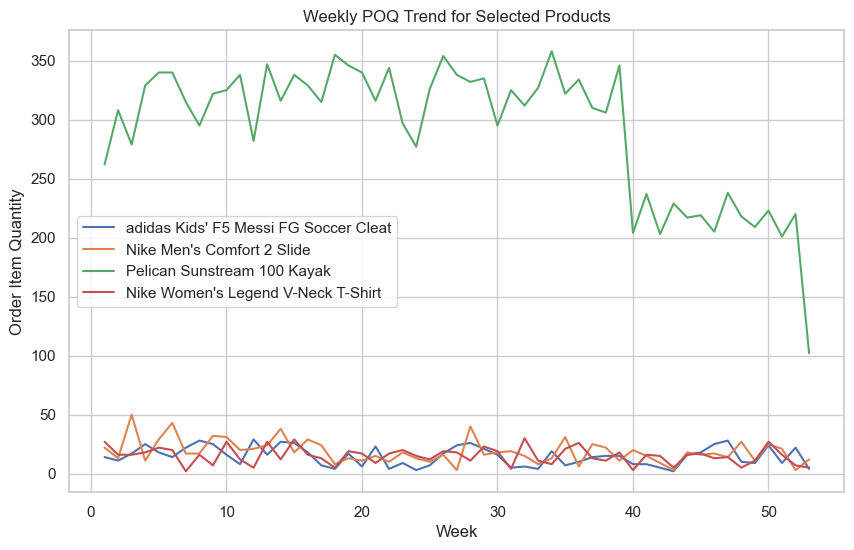

In [160]:
# Select weekly data
weekly_data = POQ_trend_week.copy()

# Choose a few products to focus on
products_to_plot = ["adidas Kids' F5 Messi FG Soccer Cleat", "Nike Men's Comfort 2 Slide", "Pelican Sunstream 100 Kayak",
                   "Nike Women's Legend V-Neck T-Shirt"]

# Create the line chart
plt.figure(figsize=(10, 6))
for product in products_to_plot:
    filtered_data = weekly_data[weekly_data["Product_Name"] == product]
    plt.plot(filtered_data["week"], filtered_data["Order_Item_Quantity"], label=product)

plt.xlabel("Week")
plt.ylabel("Order Item Quantity")
plt.title("Weekly POQ Trend for Selected Products")
plt.legend()
plt.show()

In [164]:
# Top 10 Most ordered products
sales_inventory.groupby(['Product_Card_Id', 'Product_Name'])['Order_Item_Quantity'].sum().nlargest(10)

Product_Card_Id  Product_Name                                 
365              Perfect Fitness Perfect Rip Deck                 73698
191              Nike Men's Free 5.0+ Running Shoe                73360
403              Nike Men's CJ Elite 2 TD Football Cleat          66738
502              Nike Men's Dri-FIT Victory Golf Polo             62956
1014             O'Brien Men's Neoprene Life Vest                 57803
627              Under Armour Girls' Toddler Spine Surge Runni    31735
1004             Field & Stream Sportsman 16 Gun Fire Safe        17325
1073             Pelican Sunstream 100 Kayak                      15500
957              Diamondback Women's Serene Classic Comfort Bi    13729
572              TYR Boys' Team Digi Jammer                        3520
Name: Order_Item_Quantity, dtype: int64

Text(0.5, 0, '')

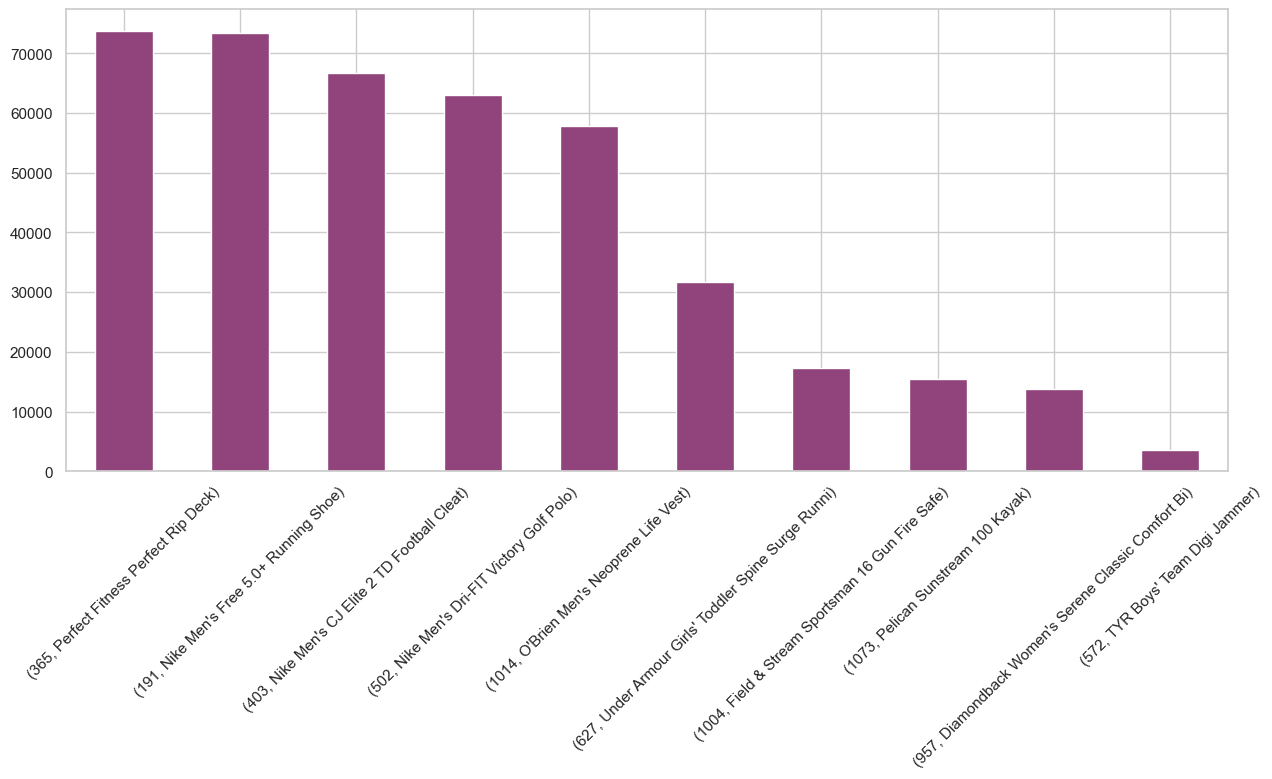

In [165]:
sales_inventory.groupby(['Product_Card_Id', 'Product_Name'])['Order_Item_Quantity'].sum().nlargest(10).plot(kind='bar',figsize=(15,6),color='#91437b')
plt.xticks(rotation=45)
plt.xlabel('')

In [166]:
# Top 10 Most ordered Categories
sales_inventory.groupby(['Product_Category_Id', 'Category_Name'])['Order_Item_Quantity'].sum().nlargest(10)

Product_Category_Id  Category_Name       
9                    Cardio Equipment        74267
17                   Cleats                  73734
18                   Men's Footwear          66738
24                   Women's Apparel         62956
46                   Indoor/Outdoor Games    57803
29                   Shop By Sport           32789
45                   Fishing                 17325
48                   Water Sports            15540
43                   Camping & Hiking        13729
40                   Accessories              7130
Name: Order_Item_Quantity, dtype: int64

In [167]:
# Top 10 cities interms of revenue
sales_inventory.groupby(['Customer_City','Customer_State','Customer_Country'])['Sales'].sum().nlargest(10)

Customer_City  Customer_State  Customer_Country
Caguas         PR              Puerto Rico         1.734102e+07
Chicago        IL              EE. UU.             1.010552e+06
Los Angeles    CA              EE. UU.             8.907679e+05
Brooklyn       NY              EE. UU.             8.704449e+05
New York       NY              EE. UU.             4.611885e+05
Philadelphia   PA              EE. UU.             4.078252e+05
Bronx          NY              EE. UU.             3.865808e+05
San Diego      CA              EE. UU.             3.732903e+05
Miami          FL              EE. UU.             3.482255e+05
Houston        TX              EE. UU.             3.375146e+05
Name: Sales, dtype: float64

In [168]:
# Top 10 cities interms of sale units (quantity)
sales_inventory.groupby(['Customer_City','Customer_State','Customer_Country'])['Order_Item_Quantity'].sum().nlargest(10)

Customer_City  Customer_State  Customer_Country
Caguas         PR              Puerto Rico         178077
Chicago        IL              EE. UU.              10303
Brooklyn       NY              EE. UU.               9161
Los Angeles    CA              EE. UU.               9086
New York       NY              EE. UU.               4832
Philadelphia   PA              EE. UU.               4266
Bronx          NY              EE. UU.               3953
San Diego      CA              EE. UU.               3835
Miami          FL              EE. UU.               3485
Houston        TX              EE. UU.               3453
Name: Order_Item_Quantity, dtype: int64

In [169]:
sales_inventory.groupby(['Category_Name','Type'])['Type'].count().nlargest(10)

Category_Name         Type    
Men's Footwear        DEBIT       25767
                      TRANSFER    18450
                      PAYMENT     15111
Cleats                DEBIT        9450
Cardio Equipment      DEBIT        9407
Women's Apparel       DEBIT        8199
Indoor/Outdoor Games  DEBIT        7436
Men's Footwear        CASH         7410
Cleats                TRANSFER     6827
Cardio Equipment      TRANSFER     6823
Name: Type, dtype: int64

In [170]:
(
    sales_inventory.groupby(['Category_Name','Type'])
    .size()
    .reset_index(name='count')
    .sort_values(['Category_Name', 'count'],ascending=[True, False])
    .groupby(['Category_Name'])
    .head(2) # change the n value --- head(n) -- to get top n
).head(10)

Category_Name      Type  count
1           Accessories     DEBIT    928
3           Accessories  TRANSFER    668
5       As Seen on  TV!     DEBIT     24
7       As Seen on  TV!  TRANSFER     19
9                 Baby      DEBIT    243
11                Baby   TRANSFER    174
13  Baseball & Softball     DEBIT    235
15  Baseball & Softball  TRANSFER    179
19           Basketball  TRANSFER     25
17           Basketball     DEBIT     24

In [171]:
top_by_category(sales_inventory,'Category_Name', 'Type',1).head(2)

Category_Name   Type  count
0      Accessories  DEBIT    928
1  As Seen on  TV!  DEBIT     24

# Which shipping mode is more efficient interms of not delaying?

In [172]:
Not_delayed = sales_inventory[sales_inventory.Late_Delivery_Risk=='Not Late']
Not_delayed.groupby('Shipping_Mode').agg(total_orders=('Order_Id', 'count'))

total_orders
Shipping_Mode               
Same Day                6856
Second Class            9651
Standard Class         87923

In [173]:
delay_rate=sales_inventory.groupby('Shipping_Mode').agg(total_orders=('Order_Id', 'count'),
                                            Not_delayed_orders=('Late_Delivery_Risk', lambda x: (x == 'Not Late').sum()),
                                            delayed_orders=('Late_Delivery_Risk', lambda x: (x == 'Late').sum()))
# Calculate delay rate as a percentage
delay_rate['delay_rate'] = (delay_rate['delayed_orders'] / delay_rate['total_orders']) * 100
delay_rate

total_orders  Not_delayed_orders  delayed_orders  delay_rate
Shipping_Mode                                                               
First Class            37433                   0           37433  100.000000
Same Day               13140                6856            6284   47.823440
Second Class           47679                9651           38028   79.758384
Standard Class        145765               87923           57842   39.681679

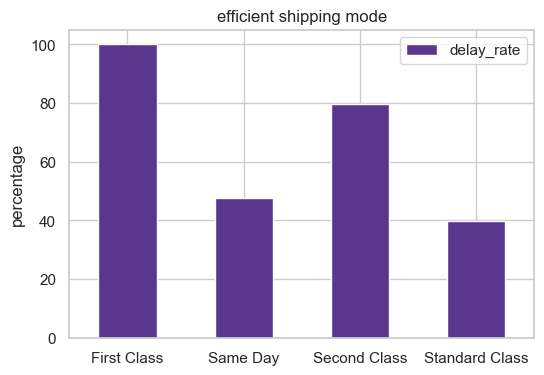

In [174]:
delay_rate[['delay_rate']].plot(kind='bar',figsize=(6,4),color='#5a368f')
plt.xticks(rotation=0)
plt.xlabel('')
plt.ylabel('percentage')
plt.title('efficient shipping mode')
plt.show()

> `Standard Class` Shipping mode is more efficient interms of not delaying

 Number of orders, sales, qty  by order status

In [175]:
# Group by order status and calculate metrics
order_status_metrics = (
    sales_inventory.groupby('Order_Status')
    .agg(total_orders=('Order_Id', 'count'),
        total_sales=('Sales', 'sum'),
        total_quantity=('Order_Item_Quantity', 'sum')).reset_index())

order_status_metrics

Order_Status  total_orders   total_sales  total_quantity
0         CANCELED          5034  9.583610e+05            9974
1           CLOSED         26665  5.142437e+06           52237
2         COMPLETE         80483  1.539894e+07          158477
3          ON_HOLD         13271  2.522203e+06           25987
4   PAYMENT_REVIEW          2491  4.801887e+05            5056
5          PENDING         27414  5.251437e+06           53973
6  PENDING_PAYMENT         53678  1.028636e+07          105717
7       PROCESSING         29457  5.709232e+06           58291
8  SUSPECTED_FRAUD          5524  1.053458e+06           10810

 Which categories are most profitable categories (top5)?

In [176]:
# Group by category and calculate profitability metrics
category_profitability = (
    sales_inventory.groupby('Category_Name')
    .agg(total_profit=('Order_Profit_Per_Order', 'sum'))
    .sort_values('total_profit', ascending=False)
    .head(5).reset_index())

category_profitability

Category_Name   total_profit
0    Men's Footwear  935708.460641
1  Cardio Equipment  762926.916988
2           Fishing  756220.767190
3            Cleats  494636.919791
4  Camping & Hiking  427455.568106

Which categoires have been given highest average discount (top5)

In [177]:
# Group by category and calculate average discount
category_avg_discount = (
    sales_inventory.groupby('Category_Name')
    .agg(avg_discount=('Order_Item_Discount_Rate', 'mean'))
    .sort_values('avg_discount', ascending=False)
    .head(5).reset_index())
category_avg_discount

Category_Name  avg_discount
0    As Seen on  TV!      0.109412
1  Strength Training      0.105829
2         Golf Shoes      0.105741
3              Baby       0.104300
4     Girls' Apparel      0.103993

### a. Value of Sales, Qty & Profit by Customer segment

In [178]:
customer_segment_analysis = sales_inventory.groupby('Customer_Segment').agg(
    total_sales=('Sales', 'sum'),
    total_quantity=('Order_Item_Quantity', 'sum'),
    total_profit=('Order_Profit_Per_Order', 'sum')).reset_index()
customer_segment_analysis

Customer_Segment   total_sales  total_quantity  total_profit
0         Consumer  2.429015e+07          249323  2.621899e+06
1        Corporate  1.422285e+07          145891  1.527806e+06
2      Home Office  8.289618e+06           85308  8.797751e+05

### b. Month wise avg sales/qty/profit 

In [179]:
seasonal_trends = sales_inventory.groupby('month').agg(
    avg_sales=('Sales', 'mean'),
    avg_quantity=('Order_Item_Quantity', 'mean'),
    avg_profit=('Order_Profit_Per_Order', 'mean')).reset_index()
seasonal_trends

month   avg_sales  avg_quantity  avg_profit
0       1  179.599866      1.916660   19.078812
1       2  188.757411      2.049432   19.167419
2       3  186.525538      2.032437   20.171546
3       4  187.938883      2.011988   20.994402
4       5  189.775024      1.993739   19.784596
5       6  191.435563      1.969789   20.038256
6       7  190.068853      1.993254   20.868064
7       8  190.214228      1.988819   21.502627
8       9  193.300416      1.967747   21.327006
9      10  222.980539      1.899643   23.334050
10     11  204.021684      1.902578   21.787045
11     12  186.838925      1.868504   20.127707

> Month 10 (October) is most profitable & grossing highest avg revenue for the company <br>
> last 5 months are more profit genearting than the other

### C. Top 2 Product catogaries by each customer segment by sales

In [180]:
category_segment_analysis = sales_inventory.groupby(['Customer_Segment', 'Category_Name']).agg(
    total_sales=('Sales', 'sum'),
    total_quantity=('Order_Item_Quantity', 'sum')).reset_index()

In [181]:
(category_segment_analysis
 .sort_values(by=['total_sales','total_quantity'],ascending=[False,False])
 .groupby(['Customer_Segment']).head(2))

Customer_Segment     Category_Name   total_sales  total_quantity
34          Consumer    Men's Footwear  4.473736e+06           34416
10          Consumer  Cardio Equipment  3.860485e+06           38923
84         Corporate    Men's Footwear  2.658426e+06           20451
60         Corporate  Cardio Equipment  2.219099e+06           22392
134      Home Office    Men's Footwear  1.543111e+06           11871
110      Home Office  Cardio Equipment  1.282892e+06           12952

### d. Analyze the frequency of orders over time

In [182]:
order_frequency_analysis = (
    sales_inventory.groupby(sales_inventory['order_date_(DateOrders)']
                            .dt.to_period("M"))
    .agg(unique_orders_count=('Order_Id', 'nunique')))

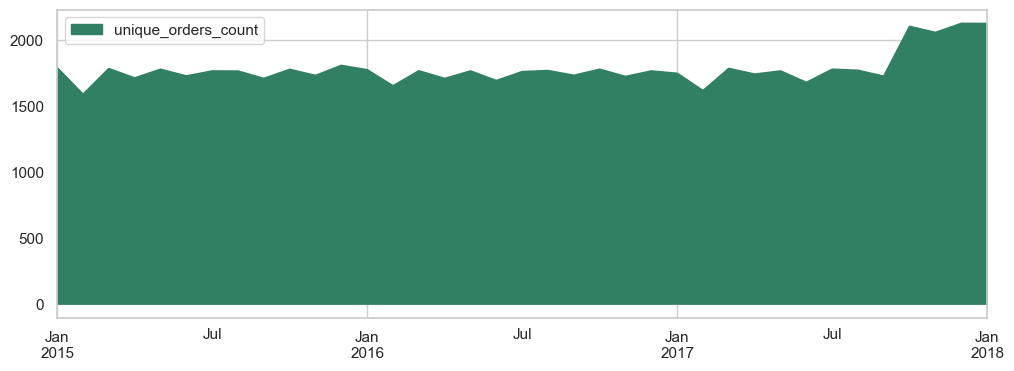

In [183]:
order_frequency_analysis.plot(kind='area',figsize=(12,4), color='#328063')
plt.xlabel('')

plt.show()

### e. Products with most Late dealivery risk

In [184]:
product_availability_analysis = (
    sales_inventory.groupby('Product_Name')
    .agg(delayed_orders=('Late_Delivery_Risk', lambda x: (x == 'Late').sum()))
    .sort_values(by=['delayed_orders'],ascending=False)).head(10).reset_index()
product_availability_analysis

Product_Name  delayed_orders
0        Nike Men's CJ Elite 2 TD Football Cleat           37992
1               Perfect Fitness Perfect Rip Deck           14053
2              Nike Men's Free 5.0+ Running Shoe           13850
3           Nike Men's Dri-FIT Victory Golf Polo           12017
4               O'Brien Men's Neoprene Life Vest           11043
5      Field & Stream Sportsman 16 Gun Fire Safe            9930
6                    Pelican Sunstream 100 Kayak            8866
7  Diamondback Women's Serene Classic Comfort Bi            7812
8  Under Armour Girls' Toddler Spine Surge Runni            6126
9                           Fighting video games             944

___

KPIs: Inventory Units, Inventory Value, Sales Units, Sales Value, Profit Value <br>
charts: Delivery Status, Status Order, Late Delivery Risk, Order Quantity Trend, Sales Tread, Profit Tread
    Inventory by Cluster, High Value-Small Number, Moderate Value Number Small, Value-Large Number

In [186]:
print('Inventory Units')
sales_inventory.Stock_levels.sum()

Inventory Units


8937351.674794232

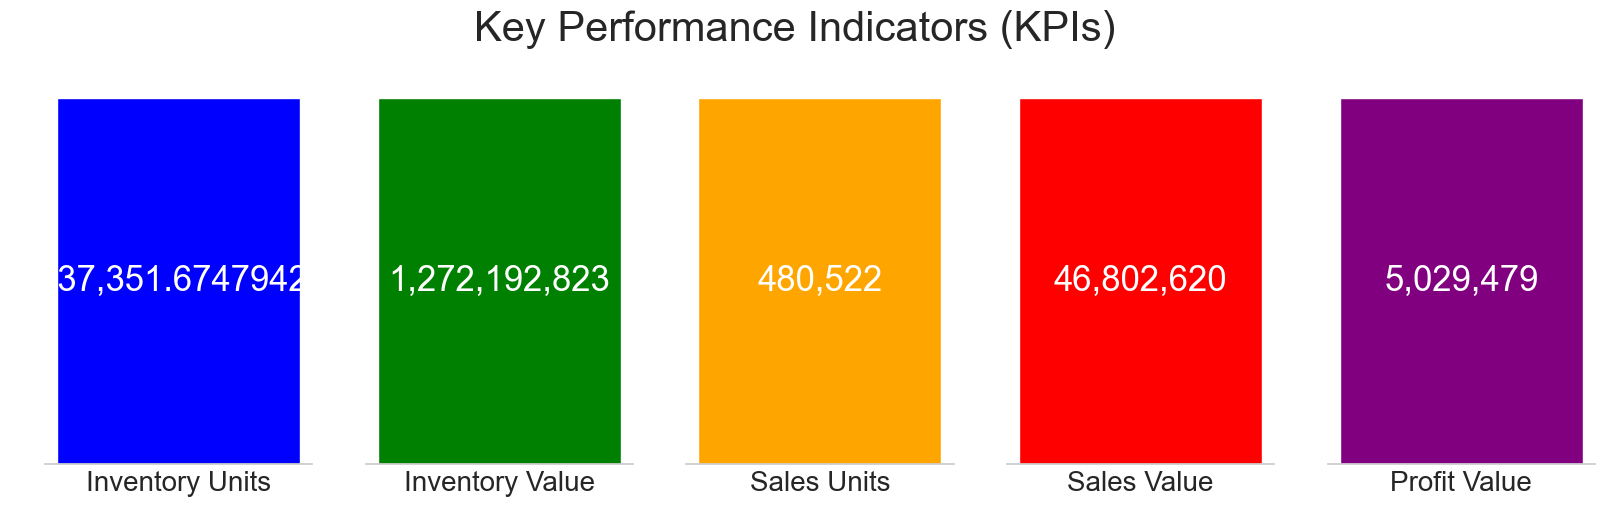

In [190]:
# Set up subplots for KPIs
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(20, 5))
fig.suptitle('Key Performance Indicators (KPIs)', y=1.02,fontsize=30)

# KPI 1: Inventory Units
inventory_units_value = sales_inventory['Stock_levels'].sum()
axes[0].bar(x=['Inventory Units'], height=[inventory_units_value], color='blue')
axes[0].text(x=0, y=inventory_units_value / 2, s=f'{inventory_units_value:,}',fontsize=25, ha='center', va='center', color='white')
axes[0].set_xlabel('Inventory Units', fontsize=20)
axes[0].set_xticks([]) 
axes[0].set_yticks([])
axes[0].spines['right'].set_color('white')
axes[0].spines['left'].set_color('white')  
axes[0].spines['top'].set_color('white')  

# KPI 2: Inventory Value
inventory_value = sales_inventory['Inventory_Value'].sum()
axes[1].bar(x=['Inventory Value'], height=[inventory_value], color='green')
axes[1].text(x=0, y=inventory_value / 2, s=f'{inventory_value:,.0f}', fontsize=25, ha='center', va='center', color='white')
axes[1].set_xlabel('Inventory Value',fontsize=20)
axes[1].set_xticks([]) 
axes[1].set_yticks([])
axes[1].spines['right'].set_color('white')
axes[1].spines['left'].set_color('white')  
axes[1].spines['top'].set_color('white') 

# KPI 3: Sales Units
sales_units = sales_inventory['Order_Item_Quantity'].sum()
axes[2].bar(x=['Sales Units'], height=[sales_units], color='orange')
axes[2].text(x=0, y=sales_units / 2, s=f'{sales_units:,}',fontsize=25, ha='center', va='center', color='white')
axes[2].set_xlabel('Sales Units',fontsize=20)
axes[2].set_xticks([]) 
axes[2].set_yticks([])
axes[2].spines['right'].set_color('white')
axes[2].spines['left'].set_color('white')  
axes[2].spines['top'].set_color('white') 

# KPI 4: Sales Value
sales_value = sales_inventory['Sales'].sum()
axes[3].bar(x=['Sales Value'], height=[sales_value], color='red')
axes[3].text(x=0, y=sales_value / 2, s=f'{sales_value:,.0f}', fontsize=25,ha='center', va='center', color='white')
axes[3].set_xlabel('Sales Value',fontsize=20)
axes[3].set_xticks([]) 
axes[3].set_yticks([])
axes[3].spines['right'].set_color('white')  
axes[3].spines['left'].set_color('white')  
axes[3].spines['top'].set_color('white') 

# KPI 5: Profit Value
profit_value = sales_inventory['Order_Profit_Per_Order'].sum()
axes[4].bar(x=['Profit Value'], height=[profit_value], color='purple')
axes[4].text(x=0, y=profit_value / 2, s=f'{profit_value:,.0f}',fontsize=25, ha='center', va='center', color='white')
axes[4].set_xlabel('Profit Value',fontsize=20)
axes[4]. set_xticks([]) 
axes[4]. set_yticks([])
axes[4].spines['right'].set_color('white')
axes[4].spines['left'].set_color('white')  
axes[4].spines['top'].set_color('white') 

# Adjust layout
plt.tight_layout(rect=[1, 1, 1, 1])
plt.show()

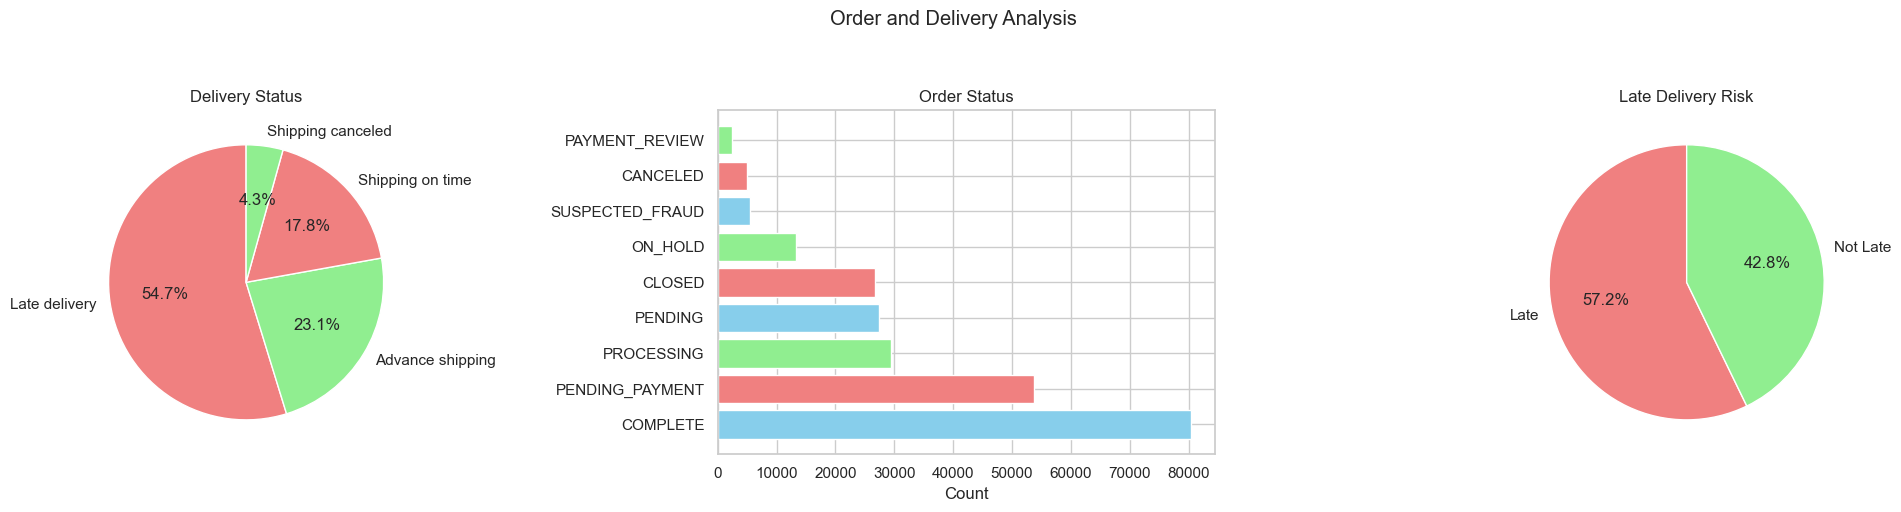

In [191]:
# Set up subplots
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 5))
fig.suptitle('Order and Delivery Analysis', y=1.02)

# Pie Chart: Delivery Status
delivery_status_counts = sales_inventory['Delivery_Status'].value_counts()
axes[0].pie(delivery_status_counts, labels=delivery_status_counts.index, autopct='%1.1f%%', startangle=90, colors=['lightcoral', 'lightgreen'])
axes[0].set_title('Delivery Status')

# Bar Chart: Order Status
order_status_counts = sales_inventory['Order_Status'].value_counts()
axes[1].barh(order_status_counts.index, order_status_counts, color=['skyblue', 'lightcoral', 'lightgreen'])
axes[1].set_title('Order Status')
axes[1].set_xlabel('Count')

# Pie Chart: Late Delivery Risk
late_delivery_risk_counts = sales_inventory['Late_Delivery_Risk'].value_counts()
axes[2].pie(late_delivery_risk_counts, labels=late_delivery_risk_counts.index, autopct='%1.1f%%', startangle=90, colors=['lightcoral', 'lightgreen'])
axes[2].set_title('Late Delivery Risk')

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

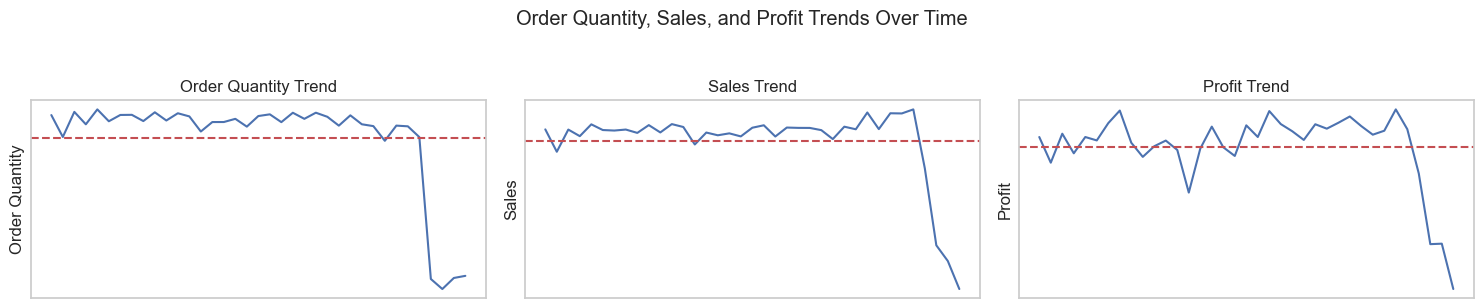

In [192]:
# Set up the style for seaborn plots
sns.set(style="whitegrid")

# Create subplots
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 3))
fig.suptitle('Order Quantity, Sales, and Profit Trends Over Time', y=1.02)

# Line Chart 1: Order Quantity Trend
OOT = sales_inventory.groupby(sales_inventory['order_date_(DateOrders)'].dt.strftime("%Y-%m"))['Order_Item_Quantity'].sum().reset_index()
sns.lineplot(x='order_date_(DateOrders)', y='Order_Item_Quantity', data=OOT, ax=axes[0])
axes[0].axhline(y=OOT['Order_Item_Quantity'].mean(), color='r', linestyle='--', label='Average Orders')
axes[0].set_title('Order Quantity Trend')
axes[0].set_ylabel('Order Quantity')
axes[0].set_xlabel("") 
axes[0].set_xticks([]) 
axes[0].set_yticks([])

# Line Chart 2: Sales Trend
ST = sales_inventory.groupby(sales_inventory['order_date_(DateOrders)'].dt.strftime("%Y-%m"))['Sales'].sum().reset_index()
sns.lineplot(x='order_date_(DateOrders)', y='Sales', data=ST, ax=axes[1])
axes[1].axhline(y=ST['Sales'].mean(), color='r', linestyle='--', label='Average Sales')
axes[1].set_title('Sales Trend')
axes[1].set_ylabel('Sales')
axes[1].set_xlabel("") 
axes[1].set_xticks([]) 
axes[1].set_yticks([])

# Line Chart 3: Profit Trend
PT = sales_inventory.groupby(sales_inventory['order_date_(DateOrders)'].dt.strftime("%Y-%m"))['Order_Profit_Per_Order'].sum().reset_index()
sns.lineplot(x='order_date_(DateOrders)', y='Order_Profit_Per_Order', data=PT, ax=axes[2])
axes[2].axhline(y=PT['Order_Profit_Per_Order'].mean(), color='r', linestyle='--', label='Average Profit')
axes[2].set_title('Profit Trend')
axes[2].set_ylabel('Profit')
axes[2].set_xlabel("") 
axes[2].set_xticks([]) 
axes[2].set_yticks([])

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

In [196]:
def categorize_inventory(row):
    if (row['Inventory_Value'] > 19500) & (row['Stock_levels'] < 63):
        return 'high_value_small_number'
    elif(row['Inventory_Value'] > 19500) & (row['Stock_levels'] > 320):
        return 'high_value_high_number'
    elif ((row['Inventory_Value'] > 8750) & (row['Inventory_Value'] < 19500)) or ((row['Stock_levels'] > 63) & (row['Stock_levels'] < 320)):
        return 'moderate_value_n_number'
    elif (row['Inventory_Value'] < 8750) & (row['Stock_levels'] > 320):
        return 'small_value_large_number'
    elif (row['Inventory_Value'] < 8750) & (row['Stock_levels'] < 63):
        return 'small_value_small_number'
    else:
        return 'other'  

In [197]:
sales_inventory['Inventory_Category'] = sales_inventory.apply(categorize_inventory, axis=1)

In [198]:
Inventory_by_cluster = sales_inventory.groupby('Inventory_Category').agg(value=('Inventory_Value','sum'),
                                                 numb=('Stock_levels','sum'))
Inventory_by_cluster

value          numb
Inventory_Category                                  
high_value_small_number   5.031042e+07  6.787476e+04
moderate_value_n_number   8.425229e+08  4.768148e+06
other                     2.936991e+05  1.959300e+04
small_value_small_number  3.790658e+08  4.081736e+06

In [199]:
chart1_data = Inventory_by_cluster[['value']]

high_value_categories = ['high_value_high_number', 'high_value_small_number']
chart2_data = Inventory_by_cluster[Inventory_by_cluster.index.isin(high_value_categories)]

chart3_data = Inventory_by_cluster[Inventory_by_cluster.index == 'moderate_value_n_number']

small_value_categories = ['small_value_large_number', 'small_value_small_number']
chart4_data = Inventory_by_cluster[Inventory_by_cluster.index.isin(small_value_categories)]

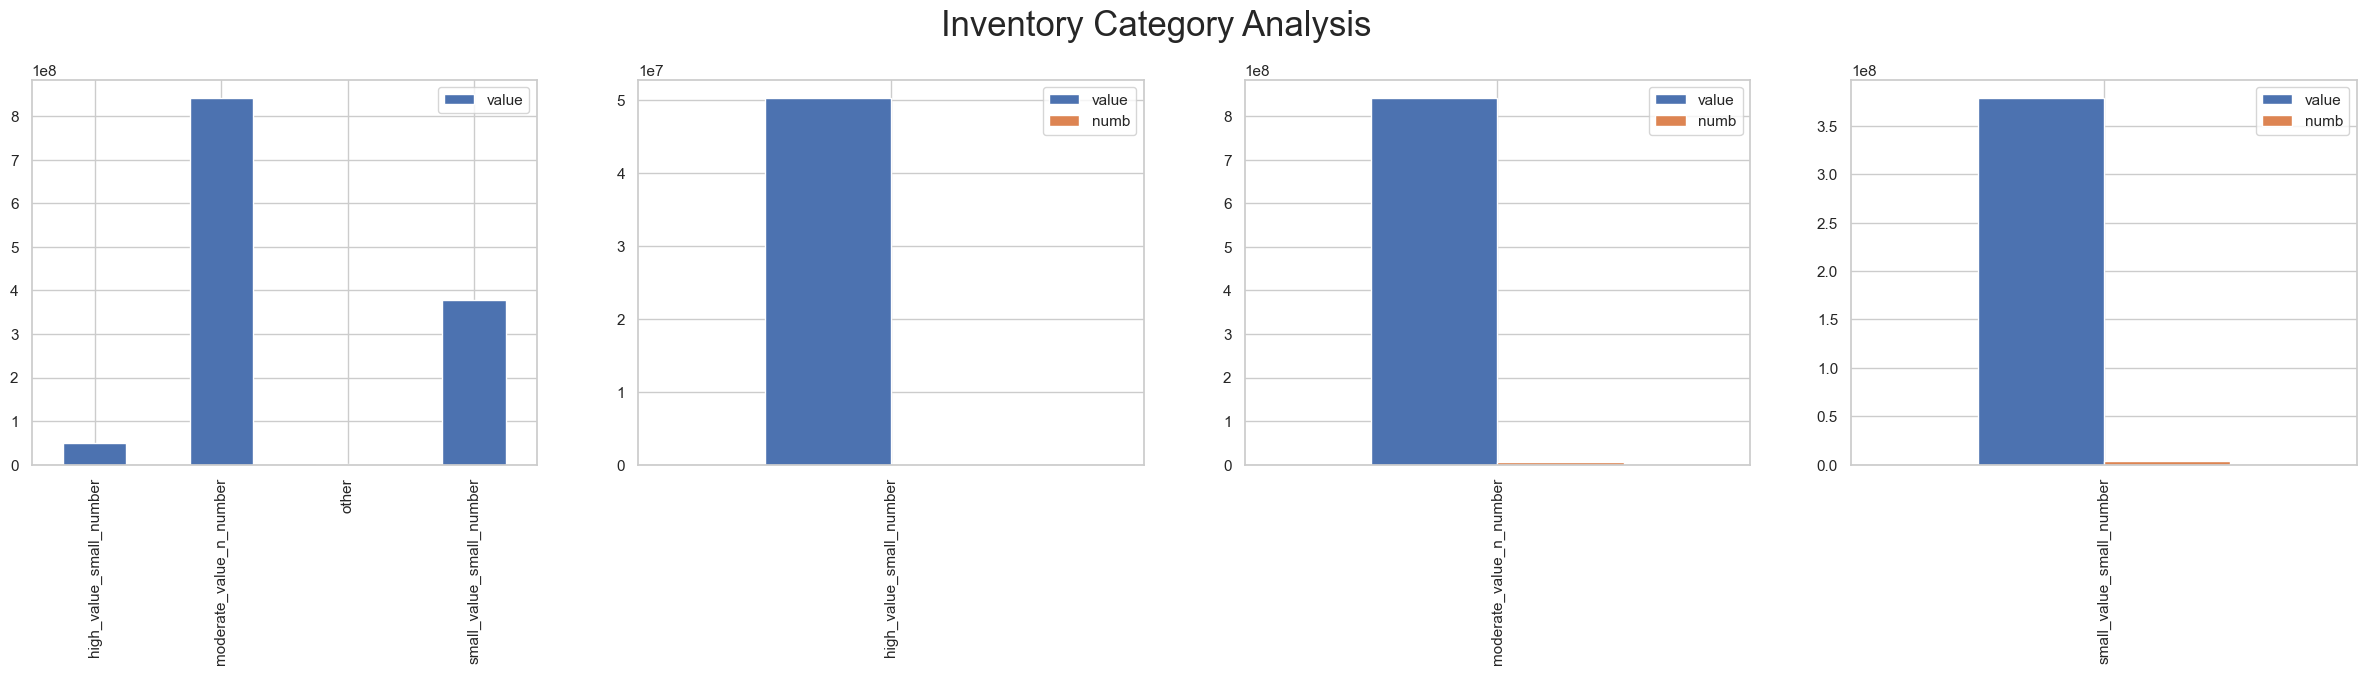

In [200]:
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(30, 5))
fig.suptitle('Inventory Category Analysis', y=1.02, fontsize=25)

# bar chart: complete Inventory_by_cluster
chart1_data.plot(ax=axes[0], kind='bar')
axes[0].set_xlabel('')

chart2_data.plot(ax=axes[1], kind='bar')
axes[1].set_xlabel('')

chart3_data.plot(ax=axes[2], kind='bar',)
axes[2].set_xlabel('')

chart4_data.plot(ax=axes[3], kind='bar')
axes[3].set_xlabel('')

plt.show()

___

##Build predictive model to predict the sales 

In [201]:
sales_inventory.columns

Index(['Type', 'Days_for_shipping_(real)', 'Days_for_shipment_(scheduled)',
       'Benefit_per_order', 'Sales_per_customer', 'Delivery_Status',
       'Late_delivery_risk', 'Category_Id', 'Category_Name', 'Customer_City',
       'Customer_Country', 'Customer_Email', 'Customer_Fname', 'Customer_Id',
       'Customer_Lname', 'Customer_Password', 'Customer_Segment',
       'Customer_State', 'Customer_Street', 'Customer_Zipcode',
       'Department_Id', 'Department_Name', 'Latitude', 'Longitude', 'Market',
       'Order_City', 'Order_Country', 'Order_Customer_Id',
       'order_date_(DateOrders)', 'Order_Id', 'Order_Item_Cardprod_Id',
       'Order_Item_Discount', 'Order_Item_Discount_Rate', 'Order_Item_Id',
       'Order_Item_Product_Price', 'Order_Item_Profit_Ratio',
       'Order_Item_Quantity', 'Sales', 'Order_Item_Total',
       'Order_Profit_Per_Order', 'Order_Region', 'Order_State', 'Order_Status',
       'Order_Zipcode', 'Product_Card_Id', 'Product_Category_Id',
       'Product_Na

Selecting columns for building a sales prediction model at customer level:

Necessary columns:
`target_variable` = 'Sales'

`Customer-related`: 'Customer_Id', 'Customer_Segment', ~'Customer_City'~, ~'Customer_State'~, 'Customer_Country',

`Order-related`: 'Order_Item_Quantity','Order_Item_Total',

`Product-related`: 'Product_Category_Id','Order_Item_Product_Price','Product_Price', Class

Redundant or unnecessary columns: Sales_per_customer, avg_lead_time, avg_order_qty, mod, 

Less relevant for customer-level sales prediction:Delivery_Status, Shipping_Mode, Order_Status, Product_Name,current_stock, reorder_point, Late_Delivery_Risk.


In [203]:
# Aggregation at Customer Level
customer_data = sales_inventory.groupby('Customer_Id').agg({
    'Customer_Segment': 'first',
    'Customer_Country': 'first',
    'Order_Item_Quantity': 'sum',
    'Order_Item_Total': 'sum',
    'Product_Category_Id': 'first',
    'Order_Item_Product_Price': 'first',
    'Product_Price': 'first',
    'Shipping_Mode': 'first',
    'Sales': 'sum'
}).reset_index()

In [204]:
customer_data.head(5)

Customer_Id Customer_Segment Customer_Country  Order_Item_Quantity  \
0            1         Consumer          EE. UU.                   10   
1            2         Consumer          EE. UU.                   19   
2            3         Consumer      Puerto Rico                   36   
3            4         Consumer          EE. UU.                   35   
4            5      Home Office      Puerto Rico                   22   

   Order_Item_Total  Product_Category_Id  Order_Item_Product_Price  \
0        944.900024                    9                 99.989998   
1       1618.660042                   29                 39.990002   
2       3479.970034                    9                 99.989998   
3       1499.449993                   17                 59.990002   
4       1510.079986                   17                 59.990002   

   Product_Price   Shipping_Mode        Sales  
0      99.989998  Standard Class   999.900024  
1      39.990002  Standard Class  1819.730034  
2      99.989998  Standard Class  3897.650103  
3      59.990002  Standard Class  1744.620029  
4      59.990002  Standard Class  1794.710045

> Since our target variable (Sales) is a continuous data, we are predicting the Sales in this model <br>
> So, we will use linear regression
>* supporting to this, we have rows > columns

In [205]:
# Create a new DataFrame with selected columns
#linear_reg_data = sales_inventory[selected_columns].copy()
linear_reg_data = customer_data.copy()

In [206]:
linear_reg_data.head(3)

Customer_Id Customer_Segment Customer_Country  Order_Item_Quantity  \
0            1         Consumer          EE. UU.                   10   
1            2         Consumer          EE. UU.                   19   
2            3         Consumer      Puerto Rico                   36   

   Order_Item_Total  Product_Category_Id  Order_Item_Product_Price  \
0        944.900024                    9                 99.989998   
1       1618.660042                   29                 39.990002   
2       3479.970034                    9                 99.989998   

   Product_Price   Shipping_Mode        Sales  
0      99.989998  Standard Class   999.900024  
1      39.990002  Standard Class  1819.730034  
2      99.989998  Standard Class  3897.650103

In [207]:
linear_reg_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20652 entries, 0 to 20651
Data columns (total 10 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Customer_Id               20652 non-null  int64  
 1   Customer_Segment          20652 non-null  object 
 2   Customer_Country          20652 non-null  object 
 3   Order_Item_Quantity       20652 non-null  int64  
 4   Order_Item_Total          20652 non-null  float64
 5   Product_Category_Id       20652 non-null  int64  
 6   Order_Item_Product_Price  20652 non-null  float64
 7   Product_Price             20652 non-null  float64
 8   Shipping_Mode             20652 non-null  object 
 9   Sales                     20652 non-null  float64
dtypes: float64(4), int64(3), object(3)
memory usage: 1.6+ MB


In [208]:
linear_reg_data.nunique()

Customer_Id                 20652
Customer_Segment                3
Customer_Country                2
Order_Item_Quantity           132
Order_Item_Total            12636
Product_Category_Id            51
Order_Item_Product_Price       75
Product_Price                  75
Shipping_Mode                   4
Sales                       12138
dtype: int64

### <code style="background:#7f848a;color:white">Outlier treatment:</code>

#### separate the categorical vs continuous variables


In [209]:
conti_data = linear_reg_data.select_dtypes(include=['number'])
cat_data = linear_reg_data.select_dtypes(include=['object'])

In [210]:
conti_vars = conti_data.columns
catg_vars = cat_data.columns

In [211]:
conti_data.apply(custom_description)

Customer_Id Order_Item_Quantity Order_Item_Total  \
dtype                          int64               int64          float64   
rows                           20652               20652            20652   
unique values                  20652                 132            12636   
non_missing                    20652               20652            20652   
missing                            0                   0                0   
missing_pct                      0.0                 0.0              0.0   
sum                        214786705              480522   42055467.85101   
var                  35917322.220357          581.447357   3913141.110338   
std                      5993.106225            24.11322      1978.166098   
mean                    10400.285929           23.267577      2036.387171   
Interquartile Range          10385.5                39.0      3107.142538   
IQR lower bound             -10369.5               -57.5     -4402.833802   
IQR upper bound              31172.5                98.5       8025.73635   
min                                1                   1             8.47   
1%                            208.51                 1.0            10.84   
5%                           1046.55                 1.0             28.9   
10%                           2090.1                 1.0        75.959999   
25%                          5208.75                 1.0       257.880005   
50%                          10407.5                18.0      1531.630003   
75%                         15594.25                40.0      3365.022543   
90%                          18691.9                58.0      4864.484073   
95%                         19724.45                69.0      5780.249031   
99%                         20550.49                90.0      7570.463825   
max                            20757                 148     12459.800052   

                    Product_Category_Id Order_Item_Product_Price  \
dtype                             int64                  float64   
rows                              20652                    20652   
unique values                        51                       75   
non_missing                       20652                    20652   
missing                               0                        0   
missing_pct                         0.0                      0.0   
sum                              879669           3872450.160229   
var                          552.932021             56819.316842   
std                           23.514507               238.368028   
mean                          42.594858               187.509692   
Interquartile Range                48.0               202.880005   
IQR lower bound                   -54.0              -254.320007   
IQR upper bound                   138.0               557.200012   
min                                   2                     9.99   
1%                                  7.0                    11.29   
5%                                  9.0                    14.99   
10%                                17.0                    31.08   
25%                                18.0                     50.0   
50%                                43.0               129.990005   
75%                                66.0               252.880005   
90%                                73.0               399.980011   
95%                                75.0               461.480011   
99%                                76.0                   1500.0   
max                                  76               1999.98999   

                      Product_Price            Sales  
dtype                       float64          float64  
rows                          20652            20652  
unique values                    75            12138  
non_missing                   20652            20652  
missing                           0                0  
missing_pct                     0.0              0.0  
sum          

> observing the above descriptions, looks like there is elevated values in <br> Order_Item_Quantity,	Order_Item_Total & Slaes column

#### Outlier Treatment using percentile method

In [212]:
conti_data = conti_data.apply(lambda x: x.clip( lower = x.quantile(0.01), upper = x.quantile(0.99) ))

> max values of Order_Item_Quantity, Order_Item Total & Slaes column might be genuine, <br> to make sure we don't proceed with outliers, as a standard approach I am clipping the 1%

#### missing value treatment 

In [213]:
conti_data.isna().sum()

Customer_Id                 0
Order_Item_Quantity         0
Order_Item_Total            0
Product_Category_Id         0
Order_Item_Product_Price    0
Product_Price               0
Sales                       0
dtype: int64

> there are no missing values

### <code style="background:#7f848a;color:white">Encode the data </code>

#### One- Hot Encoding technique (n-1) 
using: get dummies(df, drop_first = False) == True == excluding one column -- remove redundunt 

In [214]:
cat_data = pd.get_dummies(cat_data, drop_first = True )

In [215]:
cat_data.head(5)

Customer_Segment_Corporate  Customer_Segment_Home Office  \
0                           0                             0   
1                           0                             0   
2                           0                             0   
3                           0                             0   
4                           0                             1   

   Customer_Country_Puerto Rico  Shipping_Mode_Same Day  \
0                             0                       0   
1                             0                       0   
2                             1                       0   
3                             0                       0   
4                             1                       0   

   Shipping_Mode_Second Class  Shipping_Mode_Standard Class  
0                           0                             1  
1                           0                             1  
2                           0                             1  
3                           0                             1  
4                           0                             1

### <code style="background:#7f848a;color:white">Combine the Treated tables to One </code>

In [218]:
# combine categorical and continuous datasets 
linear_reg_data_new = pd.concat([cat_data, conti_data], axis = 1 )

In [219]:
linear_reg_data_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20652 entries, 0 to 20651
Data columns (total 13 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Customer_Segment_Corporate    20652 non-null  uint8  
 1   Customer_Segment_Home Office  20652 non-null  uint8  
 2   Customer_Country_Puerto Rico  20652 non-null  uint8  
 3   Shipping_Mode_Same Day        20652 non-null  uint8  
 4   Shipping_Mode_Second Class    20652 non-null  uint8  
 5   Shipping_Mode_Standard Class  20652 non-null  uint8  
 6   Customer_Id                   20652 non-null  float64
 7   Order_Item_Quantity           20652 non-null  int64  
 8   Order_Item_Total              20652 non-null  float64
 9   Product_Category_Id           20652 non-null  int64  
 10  Order_Item_Product_Price      20652 non-null  float64
 11  Product_Price                 20652 non-null  float64
 12  Sales                         20652 non-null  float64
dtypes

> Now we have all numerical data

> we have $<space>$ & $'-'$ in some of the coulmn names, to adjust them:

In [220]:
linear_reg_data_new.columns = linear_reg_data_new.columns.str.replace(' ','_')

In [221]:
linear_reg_data_new.columns = linear_reg_data_new.columns.str.replace('.','_')
linear_reg_data_new.columns = linear_reg_data_new.columns.str.replace("'",'_')
linear_reg_data_new.columns = linear_reg_data_new.columns.str.replace("&",'n')
linear_reg_data_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20652 entries, 0 to 20651
Data columns (total 13 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Customer_Segment_Corporate    20652 non-null  uint8  
 1   Customer_Segment_Home_Office  20652 non-null  uint8  
 2   Customer_Country_Puerto_Rico  20652 non-null  uint8  
 3   Shipping_Mode_Same_Day        20652 non-null  uint8  
 4   Shipping_Mode_Second_Class    20652 non-null  uint8  
 5   Shipping_Mode_Standard_Class  20652 non-null  uint8  
 6   Customer_Id                   20652 non-null  float64
 7   Order_Item_Quantity           20652 non-null  int64  
 8   Order_Item_Total              20652 non-null  float64
 9   Product_Category_Id           20652 non-null  int64  
 10  Order_Item_Product_Price      20652 non-null  float64
 11  Product_Price                 20652 non-null  float64
 12  Sales                         20652 non-null  float64
dtypes

___

#### CHecking the correlation of x variable with y

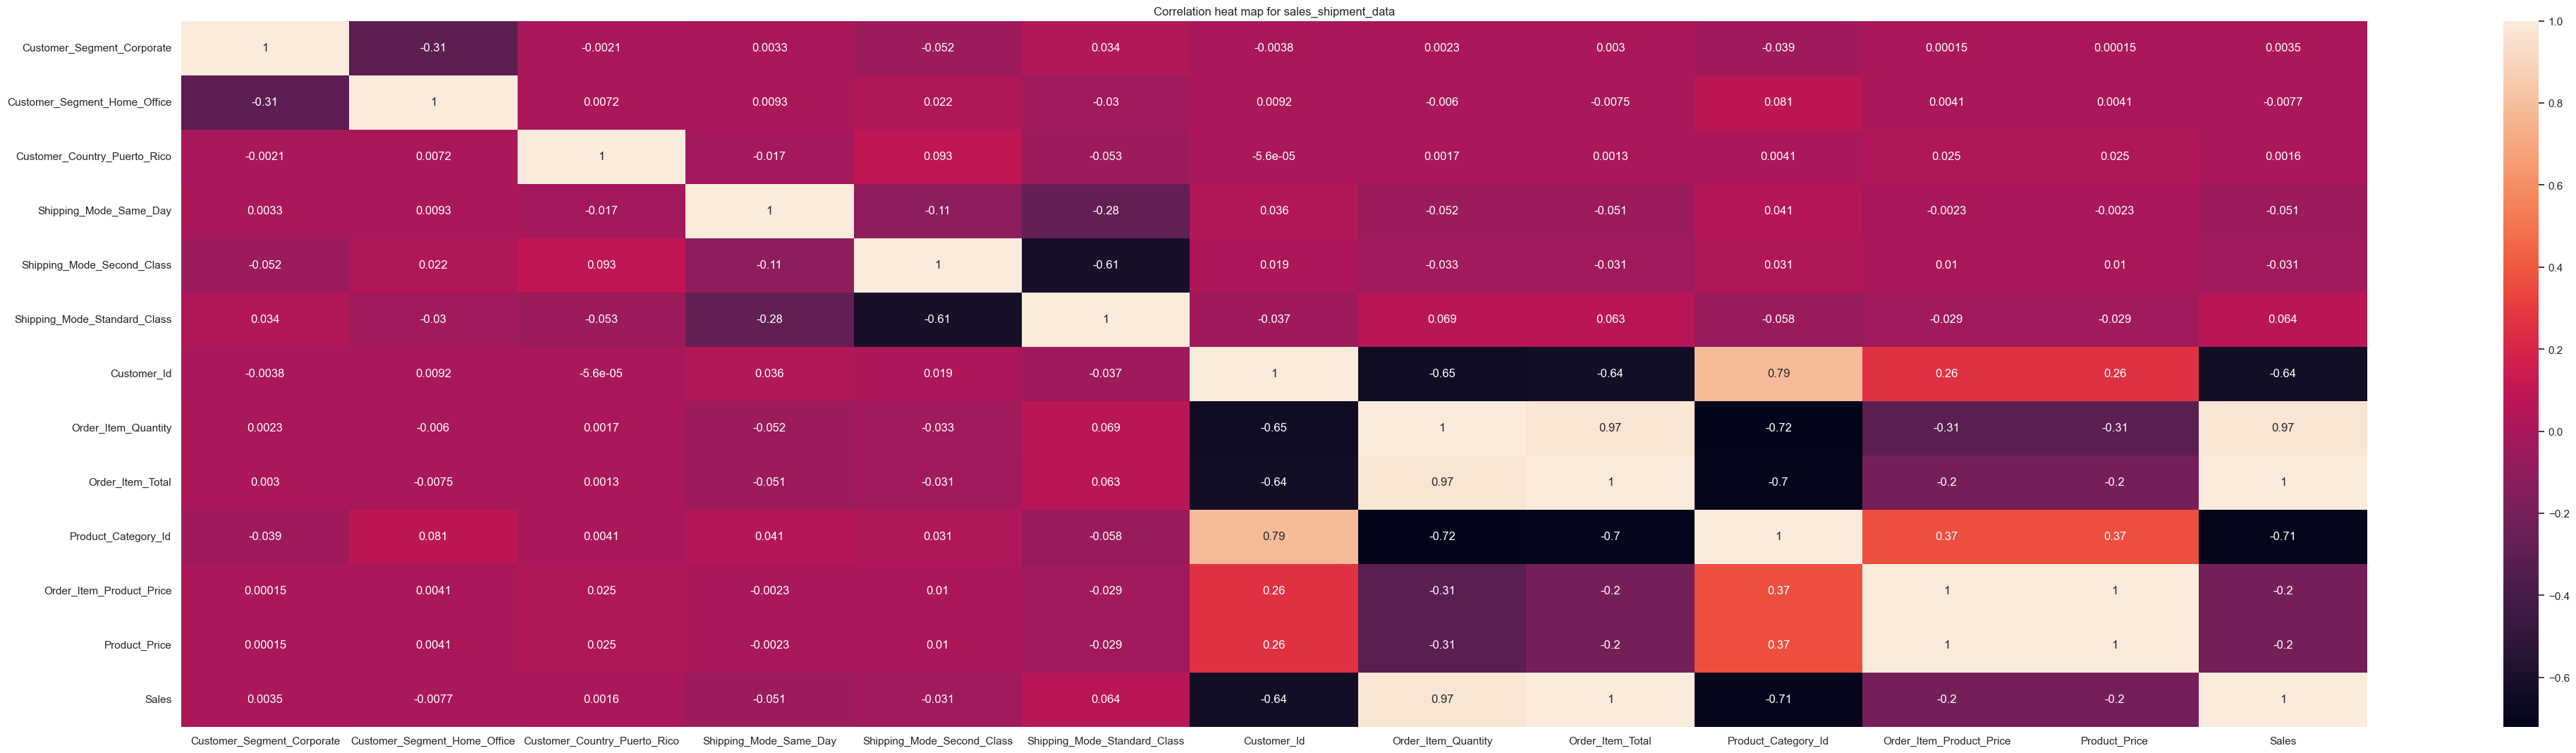

In [222]:
plt.figure(figsize=(50,13))
htmp = sns.heatmap(linear_reg_data_new.corr(),annot=True)
htmp.set_title('Correlation heat map for sales_shipment_data')
plt.show()

___

### <code style="background:#7f848a;color:white">Check the Normality Assumption </code>
Checking the Normality on Y variable

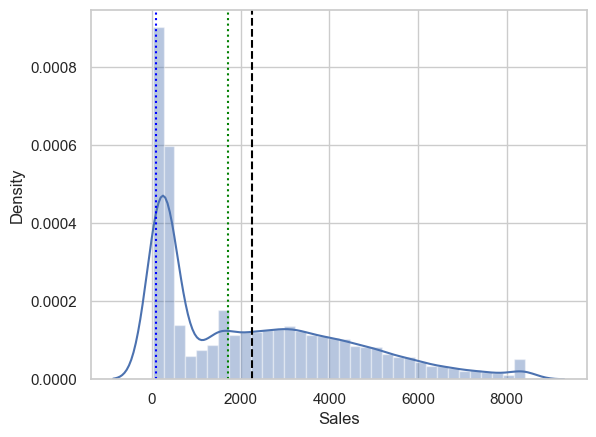

In [223]:
sns.distplot(linear_reg_data_new.Sales)

# Calculate the mean, median, and mode
mean = linear_reg_data_new.Sales.mean()
median = linear_reg_data_new.Sales.median()
mode = linear_reg_data_new.Sales.mode()[0]

# Annotate the plot with the mean, median, and mode
plt.axvline(mean, color='black', linestyle='--', label=f'Mean: {mean:.2f}')
plt.axvline(median, color='green', linestyle=':', label=f'Median: {median:.2f}')
plt.axvline(mode, color='blue', linestyle=':', label=f'Mode: {mode:.2f}')

# Add labels and title
plt.xlabel('Sales')

# Show the plot
plt.show()

In [224]:
linear_reg_data_new.Sales.kurtosis()

-0.22273052262257131

> It seems, our target variable is negatively skewed

### <code style="background:#7f848a;color:white">Bring it to Normality (Normal Distribution)</code>

#### Log Transformation

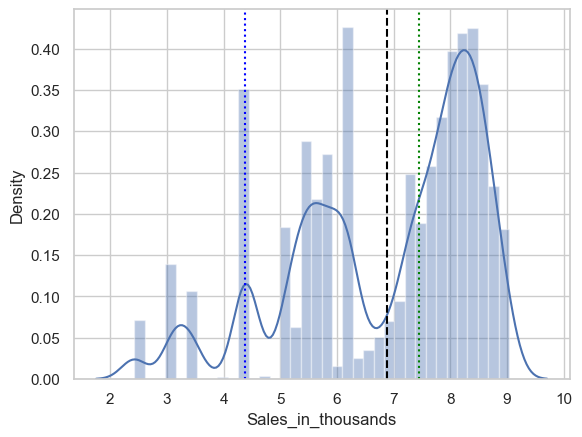

In [225]:
sns.distplot(np.log(linear_reg_data_new.Sales))

mean = np.log(linear_reg_data_new.Sales).mean()
median = np.log(linear_reg_data_new.Sales).median()
mode = np.log(linear_reg_data_new.Sales).mode()[0]

plt.axvline(mean, color='black', linestyle='--', label=f'Mean: {mean:.2f}')
plt.axvline(median, color='green', linestyle=':', label=f'Median: {median:.2f}')
plt.axvline(mode, color='blue', linestyle=':', label=f'Mode: {mode:.2f}')

plt.xlabel('Sales_in_thousands')

plt.show()

In [226]:
np.log(linear_reg_data_new.Sales).kurtosis()

-0.3454145017976802

> kurtosis is close to '0' <br>
> now our target variable seems to be normally distributed

In [227]:
linear_reg_data_new['log_Sales']=np.log(linear_reg_data_new.Sales)

### <code style="background:#7f848a;color:white">Divide the dataset into Train-Test</code>

In [228]:
# this is the methodl, which will be used for the input to smf 
train, test = train_test_split(linear_reg_data_new, test_size = 0.2, random_state = 1)

# random_state = num :: to avoid shuffling of the train-test data after re-run.

In [229]:
print('cars data:',linear_reg_data_new.shape)
print("---")
print('train data:',train.shape,'| ','test data',test.shape)

cars data: (20652, 14)
---
train data: (16521, 14) |  test data (4131, 14)


### <code style="background:#7f848a;color:white">Model Building</code>

> __y = f(x)__ = (x1 + x2 + x3 + ... + Xn)

In [230]:
# submitting the x & y variable required for the formula of the algorithm
X_vars = linear_reg_data_new.columns.difference(['Sales','log_Sales'])  #...exclude these columns & select everything
y_var = 'log_Sales'

In [231]:
# define the model equation 
formula_lm = 'log_Sales ~' + ' + '.join( X_vars )

In [232]:
formula_lm

'log_Sales ~Customer_Country_Puerto_Rico + Customer_Id + Customer_Segment_Corporate + Customer_Segment_Home_Office + Order_Item_Product_Price + Order_Item_Quantity + Order_Item_Total + Product_Category_Id + Product_Price + Shipping_Mode_Same_Day + Shipping_Mode_Second_Class + Shipping_Mode_Standard_Class'

### <code style="background:#7f848a;color:white">Model Initiation</code>

In [233]:
# fit the model or model initialization step 
model = smf.ols(formula_lm, train).fit()

In [234]:
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:              log_Sales   R-squared:                       0.862
Model:                            OLS   Adj. R-squared:                  0.862
Method:                 Least Squares   F-statistic:                     9408.
Date:                Sun, 14 Jul 2024   Prob (F-statistic):               0.00
Time:                        12:33:20   Log-Likelihood:                -15158.
No. Observations:               16521   AIC:                         3.034e+04
Df Residuals:                   16509   BIC:                         3.043e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept       

### <code style="background:#7f848a;color:white">Prediction</code>

In [235]:
#model. predict(train) -- in log format
# using np.exp to bring it back to basic units
np.exp(model.predict(train)) 

1771      3135.784491
11570     1416.677042
6370      4592.753164
8775      2724.788332
2582      3421.927761
             ...     
10955     2100.263144
17289      131.950811
5192      5822.675799
12172     1737.022465
235      16152.537152
Length: 16521, dtype: float64

In [236]:
train.Sales

1771     2234.790016
11570    2349.650066
6370     5759.350106
8775     3499.630074
2582     3364.640081
            ...     
10955    2389.630032
17289     215.820007
5192     5189.480076
12172    3017.570065
235      7378.080133
Name: Sales, Length: 16521, dtype: float64

In [237]:
# MSE - Mean squared Error 
mse_train = mean_squared_error ( train.Sales, np.exp(model.predict(train)) ) 
mse_test = mean_squared_error( test.Sales, np.exp(model.predict (test)) ) 
print ( 'MSE: ', mse_train, mse_test) 
print ( ' RMSE Train : ', np.sqrt(mse_train),'| RMSE Test : ', np.sqrt(mse_test))

MSE:  6145476.866331359 7814482.590605975
 RMSE Train :  2479.007234021587 | RMSE Test :  2795.4396059664705


### <code style="background:#7f848a;color:white">Interpreting the results of a linear regression model:</code>
> __R-squared__: The high R-squared value of 0.85 indicates that approximately 85% of the variance in log-transformed sales is explained by the model. This suggests that the selected features are effective in predicting sales

> __Coefficients__: Positive coefficients in the model indicate a positive relationship with sales, while negative coefficients indicate a negative relationship.

> __p-values__ (p-values associated with each coefficient): Lower p-values (< 0.05) suggest that the variable is statistically significant in predicting sales. 

> __Intercept__: The intercept represents the estimated 'y' (log-transformed sales) when all 'x' (independent variables) are zero.

> __RMSE__ (Root Mean Squared Error): Represents the average magnitude of the residuals (the differences between predicted and actual values). <br> Lower RMSE values indicate better model performance. In your case, the RMSE values are around 1651.82 for the training set and 1542.10 for the test set

----